In [286]:
import pandas as pd
import pandas_datareader.data as web
import seaborn
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import numpy as np
import datetime as dt
import sqlite3
import time
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from financetoolkit import Toolkit
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
import plotly.express as px
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import pandas_datareader.data as web
from dateutil.relativedelta import relativedelta
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")

class Macro:
    
    """
    This class is mainly for my paper trading in spot markets. Derivatives will have a separate script. 
    """
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*50)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.symbols_list = "USREC","RSXFS","RSAFS","RSFHFS","RSCCAS","RSFSDP","RSGCS","RSEAS","RSGASS","RSBMGESD","RSFSXMV","RSNSR","RSMVPD","RSDSELD","RRSFS","RSDBS","MARTSSM44W72USS","RSHPCS","RSSGHBMS","RSGMS","RSAOMV","RSMSR","MARTSSM44Z72USS","CPIAUCSL"

    def macro(self):
        symbols = []
        for ticker in self.symbols_list: 
            try:
                r = web.DataReader(ticker,'fred', self.fred_start, self.fred_end)
                r['ticker'] = ticker
                symbols.append(r)
            except:
                msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
        try:
            connection = sqlite3.connect('tradable_universe')
            for i in symbols:
                i.columns = 'close','ticker'
            final = pd.concat(symbols)
            final_df = final.reset_index()
            final_df.to_sql("macro_signals",connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
        except:
            print("There was an error in uploading the macro table into the sql database")
        return symbols, final_df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'close')
        return df[start:end]
    
class Trading:
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*35)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.ticker_list = ["SPY",'RSP',"XLV","VNQ","XLP","XLU","MUB","SPLV","DEF","XLRE","IEF",
                            "GDXJ","MBB", "UUP","IIGD","PINK","IWM","XLP","HG=F","GC=F",'XLY','^DJT','^SP500-55',
                           '^SP500-30','^SP500-25','XLK','^RUT','TLT','GLD','QQQ','GDX','GDXJ','XOP','KRE',
                           'XBI','XLF','XLE','XRT','XLI','XHB','XLP','JNK','DIA','XME','SRLN','XLC','XLB','BIL',
                           'MDY','KBE','SJNK','CWB','SDY','FEZ','XAR','GNR','KIE','XES','XSW','XSD','GXC','SPEM',
                           'SPDW','XTN','SPMB','SLYV','EFIV','EFAX','MDYV','AGG','LQD','^VIX','^VVIX'] 
    
    def yahoo_universe(self):
        web3 = []
        failed = []
        for security in self.ticker_list:
            try:                                                    
                interval = '1d' 
                query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{security}?period1={self.period1}&period2={self.period2}&interval={self.interval}&events=history&includeAdjustedClose=true'
                df = pd.read_csv(query_string).set_index("Date")
                df['ticker'] = security
                df.columns = ['Open', 'High', 'Low','Close','Adj Close','Volume','ticker']
                web3.append(df)
            except:
                failed.append(security)                                                
                pass
            final = pd.concat(web3)
            df_final = final.reset_index()
        return df_final, web3, failed

    
    def trading_sql(self, data_file):
        try:
            conn = sqlite3.connect('tradable_universe') 
            data_file.to_sql("consensusinvestable", conn, if_exists='replace', index = False)
            conn.commit()
            conn.close()
            print("Updating the sql table was a success")
        except:
            print("Was unsuccessful in uploading the dataframe into the datatable. ")
    
    
    def to_trading_sql(self, data):
        
        """
        Inputs: dataframe you want to upload
        Outputs: saves SQL table to the investable database 
        """
        
        try:
            connection = sqlite3.connect(config.db_file)
            data.to_sql("consensusinvestable", connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
            print("Uploading dataframe to database worked successfully.")
        except:
            print("Was unable to save the dataframe into the investable datatable.")

    
    def load_sql(self):
        try:
            conn = sqlite3.connect('tradable_universe') 
            df = pd.read_sql_query("SELECT * from consensusinvestable", conn)
            conn.commit()
            conn.close()
        except:
            print("Could not retrieve the datatable. ")
        return df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'Adj Close')
        return df[start:end]

In [287]:
initial = Macro(0, '2010-01-01','2023-05-01')

In [288]:
inst = initial.macro()
data = inst[1]

In [307]:
tickers = ['RSXFS','MARTSSM44W72USS','RSAFS']
rec = ["USREC"]  
start = '1992-01-01'
end = dt.datetime.now()
usrec_data = initial.dataframe(rec, data.set_index("DATE"), start, end)
df_data = initial.dataframe(tickers, data.set_index("DATE"), start, end)
retail_sales = ((df_data / df_data.shift(12))-1).dropna()
retail_sales = retail_sales.rename(columns={'RSXFS':"Advance Retail Sales: Retail Trade",'MARTSSM44W72USS':"Advance Retail Sales: Retail Trade and Food Services, Excluding Motor Vehicle and Parts Dealers and Gasoline Stations",
                                            "RSAFS":"Advance Retail Sales: Retail Trade and Food Services"})

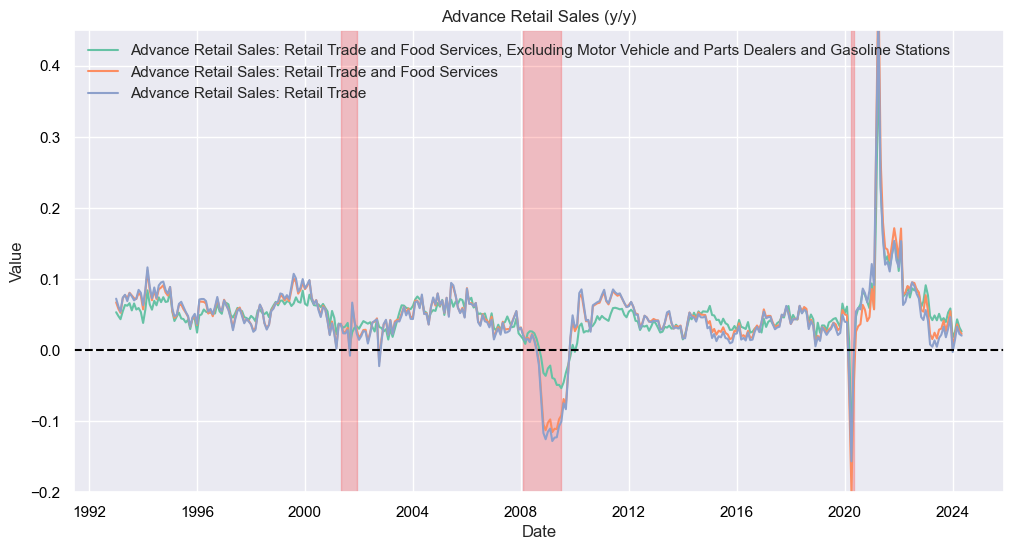

In [308]:
def fetch_recession_periods(usrec, start_date, end_date):
    recessions = {}
    recession_num = 0
    start = None
    for i in range(len(usrec)):
        if usrec.iloc[i, 0] == 1:  
            if start is None:  
                start = usrec.index[i]  
                start = datetime(start.year, start.month, calendar.monthrange(start.year, start.month)[1])
            end = usrec.index[i]
            end = datetime(end.year, end.month, calendar.monthrange(end.year, end.month)[1])
        elif start is not None:  
            recession_num += 1
            recessions[recession_num] = {'start': start.strftime('%Y-%m-%d'), 'end': end.strftime('%Y-%m-%d')}
            start = None  
    if start is not None:
        recession_num += 1
        recessions[recession_num] = {'start': start.strftime('%Y-%m-%d'), 'end': end.strftime('%Y-%m-%d')}
    if usrec.iloc[0, 0] == 1:
        first_start = usrec.index[0] - pd.offsets.MonthBegin(1)
        first_start = datetime(first_start.year, first_start.month, calendar.monthrange(first_start.year, first_start.month)[1])
        recessions[1]['start'] = first_start.strftime('%Y-%m-%d')
    return recessions

def add_recession_bands(ax, recessions, start_date, end_date):
    plot_start_date = pd.to_datetime(start_date)
    plot_end_date = pd.to_datetime(end_date)
    for rec_num, rec_dates in recessions.items():
        rec_start_date = pd.to_datetime(rec_dates['start'])
        rec_end_date = pd.to_datetime(rec_dates['end'])
        if (rec_start_date <= plot_end_date) and (rec_end_date >= plot_start_date):
            ax.axvspan(rec_start_date, rec_end_date, color="red", alpha=0.2)

def eco_plot(df_data, start_date, end_date, title, y_min, y_max , xline, xupperline, plot=False, save_fig=False):
    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.lineplot(data=df_data, dashes=False, ax=ax, palette="Set2")  # "tab10", viridis, hls, "Set2"
        ax.set_title(title)
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.legend(frameon=False, loc = 'upper left')
        ax.tick_params(axis='x', colors='black')  
        ax.tick_params(axis='y', colors='black')  
        recessions = fetch_recession_periods(usrec_data,'1960-01-01', end_date)
        add_recession_bands(ax, recessions, start_date, end_date)
        ax.set_ylim(y_min, y_max)
        plt.axhline(xline, color='black', linestyle='--')
        plt.axhline(xupperline, color='black', linestyle='--')
        if save_fig:
            plt.savefig(f'{end_date}_cf_nai.png', bbox_inches='tight', transparent=False)
        plt.show()
    else:
        return df_data

eco_plot(retail_sales, start, end, 'Advance Retail Sales (y/y)', -.20, .45, 00, 100, plot=True, save_fig=False)

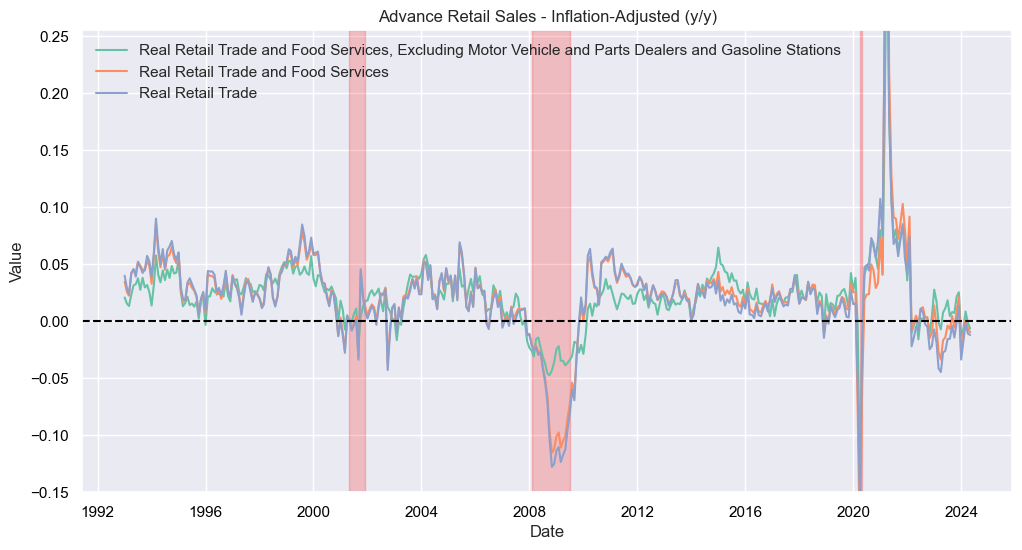

In [309]:
tickers = ['RSXFS','MARTSSM44W72USS','RSAFS',"CPIAUCSL"]
start = '1992-01-01'
end = dt.datetime.now()
df_data = initial.dataframe(tickers, data.set_index("DATE"), start, end)
retail_sales = ((df_data / df_data.shift(12))-1).dropna()
retail_sales = retail_sales.rename(columns={'RSXFS':"Advance Retail Sales: Retail Trade",'MARTSSM44W72USS':"Advance Retail Sales: Retail Trade and Food Services, Excluding Motor Vehicle and Parts Dealers and Gasoline Stations",
                                            "RSAFS":"Advance Retail Sales: Retail Trade and Food Services","CPIAUCSL":"Headline CPI"})
retail_sales["Real Retail Trade and Food Services, Excluding Motor Vehicle and Parts Dealers and Gasoline Stations"] = retail_sales["Advance Retail Sales: Retail Trade and Food Services, Excluding Motor Vehicle and Parts Dealers and Gasoline Stations"] - retail_sales["Headline CPI"]
retail_sales["Real Retail Trade and Food Services"] = retail_sales["Advance Retail Sales: Retail Trade and Food Services"] - retail_sales["Headline CPI"]
retail_sales["Real Retail Trade"] = retail_sales["Advance Retail Sales: Retail Trade"] - retail_sales["Headline CPI"]
real_retail_sales = retail_sales[["Real Retail Trade and Food Services, Excluding Motor Vehicle and Parts Dealers and Gasoline Stations","Real Retail Trade and Food Services",
                                  "Real Retail Trade"]]
eco_plot(real_retail_sales, start, end, 'Advance Retail Sales - Inflation-Adjusted (y/y)', -.15, .255, 00, 100, plot=True, save_fig=False)

In [224]:
all = data.pivot_table(index='DATE',columns='ticker',values='close').dropna()
all = all.rename(columns = {"RSXFS":"Advance Retail Sales: Retail Trade", "RSAFS":"Advance Retail Sales: Retail Trade and Food Services", "RSFHFS":"Advance Retail Sales: Furniture and Home Furnishings Stores",
                            "RSCCAS":"Advance Retail Sales: Clothing and Clothing Accessory Stores", "RSFSDP":"Advance Retail Sales: Food Services and Drinking Places",
                            "RSGCS":"Advance Retail Sales: Grocery Stores","RSEAS":"Advance Retail Sales: Electronics and Appliance Stores","RSGASS":"Advance Retail Sales: Gasoline Stations",  
                            "RSBMGESD":"Advance Retail Sales: Building Materials, Garden Equipment and Supplies Dealers",
                            "RSFSXMV":"Advance Retail Sales: Retail Trade and Food Services, Excluding Motor Vehicle and Parts Dealers",  
                            "RSNSR":"Advance Retail Sales: Nonstore Retailers", "RSMVPD":"Advance Retail Sales: Motor Vehicle and Parts Dealers", 
                            "RSDSELD":"Advance Retail Sales: Department Stores",  "RRSFS":"Advance Real Retail and Food Services Sales",
                            "RSDBS":"Advance Retail Sales: Food and Beverage Stores", 
                            "MARTSSM44W72USS":"Advance Retail Sales: Retail Trade and Food Services, Excluding Motor Vehicle and Parts Dealers and Gasoline Stations",	
                            "RSHPCS":"Advance Retail Sales: Health and Personal Care Stores", "RSGMS":"Advance Retail Sales: General Merchandise Stores", 
                            "RSSGHBMS":"Advance Retail Sales: Sporting Goods, Hobby, Musical Instrument, and Book Stores",
                            "RSAOMV":"Advance Retail Sales: Auto and Other Motor Vehicle Dealers", "RSMSR":"Advance Retail Sales: Miscellaneous Store Retailers", 
                            "MARTSSM44Z72USS":"Advance Retail Sales: Retail Trade and Food Services, Excluding Gasoline Stations"})
all_mm_diff = all - all.shift(1)
all_yy_diff = all - all.shift(12)

all_mm = (all / all.shift(1))-1
all_yy = (all / all.shift(12))-1
all_2y = (all / all.shift(24))-1

Difference m/m

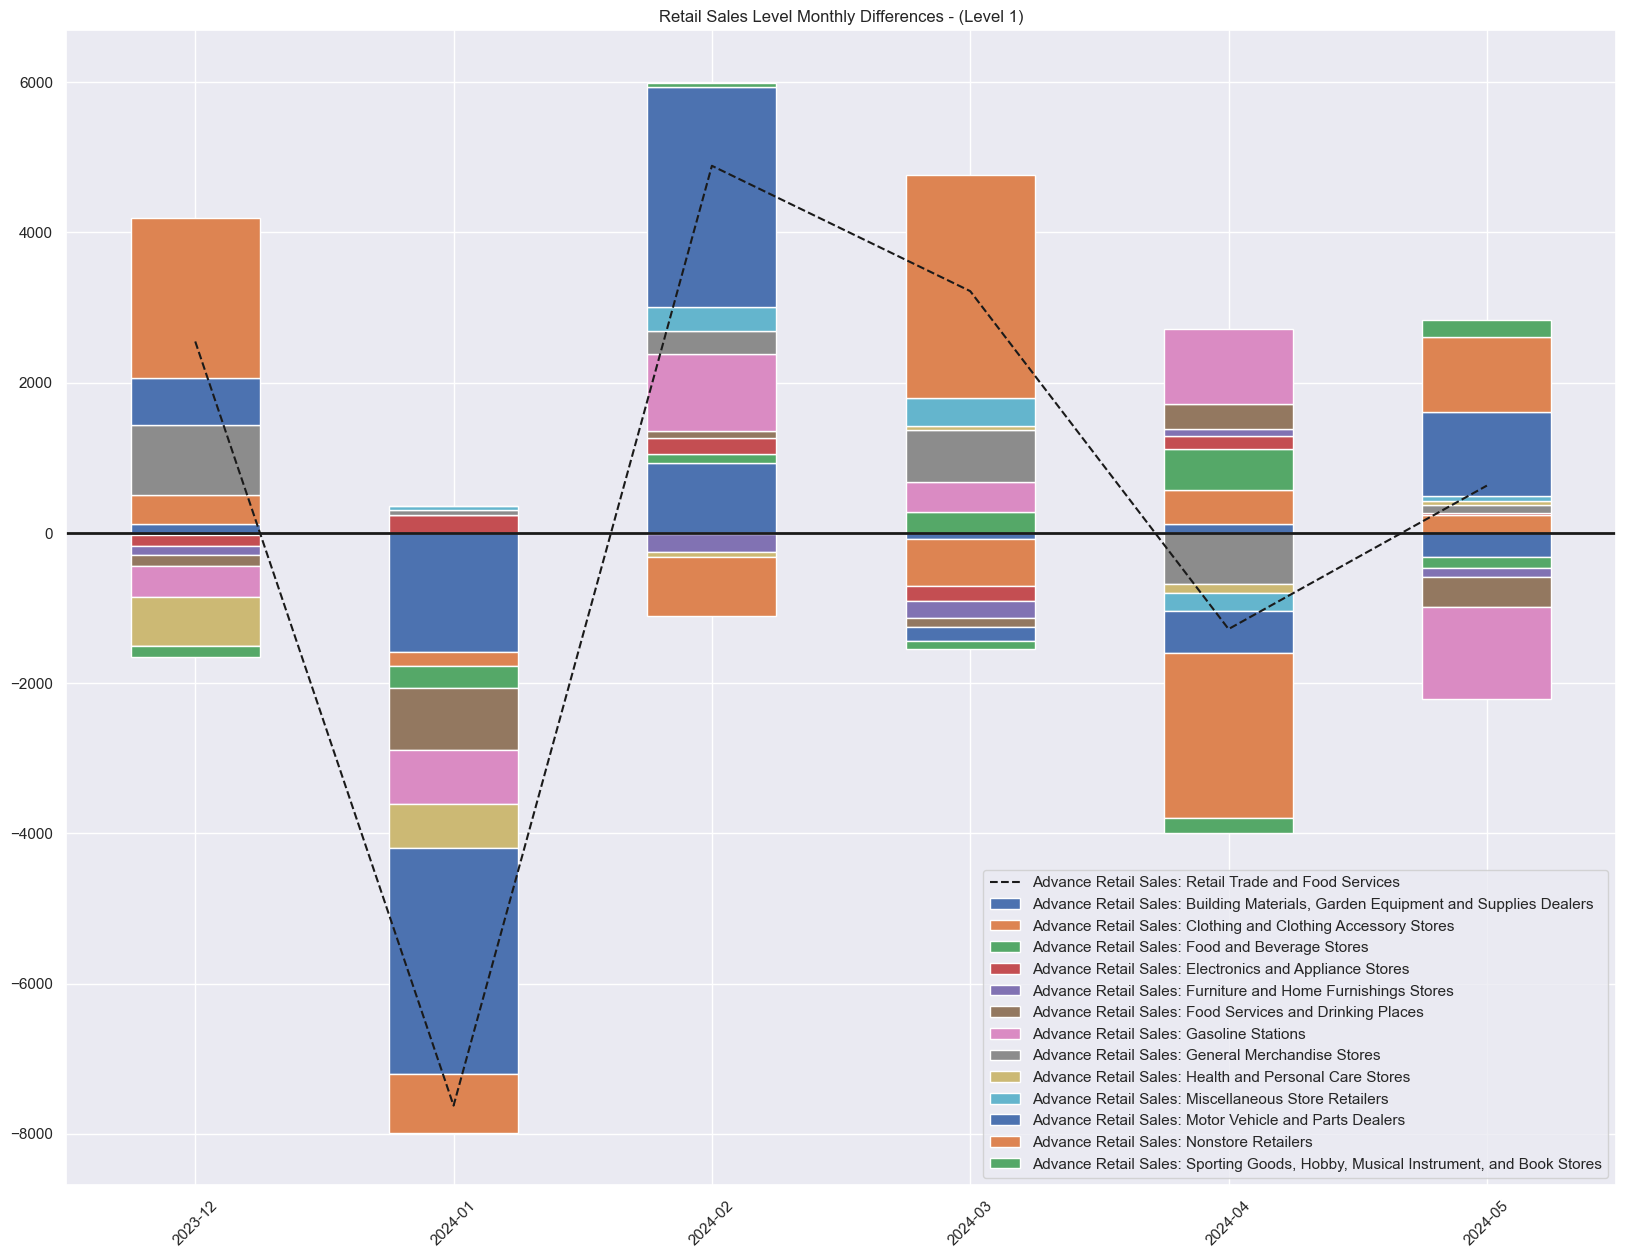

In [236]:
sales_mm_diff = all_mm_diff[['Advance Retail Sales: Retail Trade and Food Services',
    'Advance Retail Sales: Building Materials, Garden Equipment and Supplies Dealers',
       'Advance Retail Sales: Clothing and Clothing Accessory Stores',
       'Advance Retail Sales: Food and Beverage Stores',
       'Advance Retail Sales: Electronics and Appliance Stores',
       'Advance Retail Sales: Furniture and Home Furnishings Stores',
       'Advance Retail Sales: Food Services and Drinking Places',
       'Advance Retail Sales: Gasoline Stations',
       'Advance Retail Sales: General Merchandise Stores',
       'Advance Retail Sales: Health and Personal Care Stores',
       'Advance Retail Sales: Miscellaneous Store Retailers',
       'Advance Retail Sales: Motor Vehicle and Parts Dealers',
       'Advance Retail Sales: Nonstore Retailers',
       'Advance Retail Sales: Sporting Goods, Hobby, Musical Instrument, and Book Stores']]['2023-12-01':]

ax = sales_mm_diff.iloc[:,0].plot(figsize=(20,15), grid = False, title = "Retail Sales Level Monthly Differences - (Level 1)",
                                  xlabel = '',rot=45, linestyle = '--',color ='k', use_index = False)
sales_mm_diff.iloc[:,1:].plot.bar(ax=ax, stacked=True, grid=True, xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.legend(loc='best')  # upper right, lower right 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sales_mm_diff.index)))

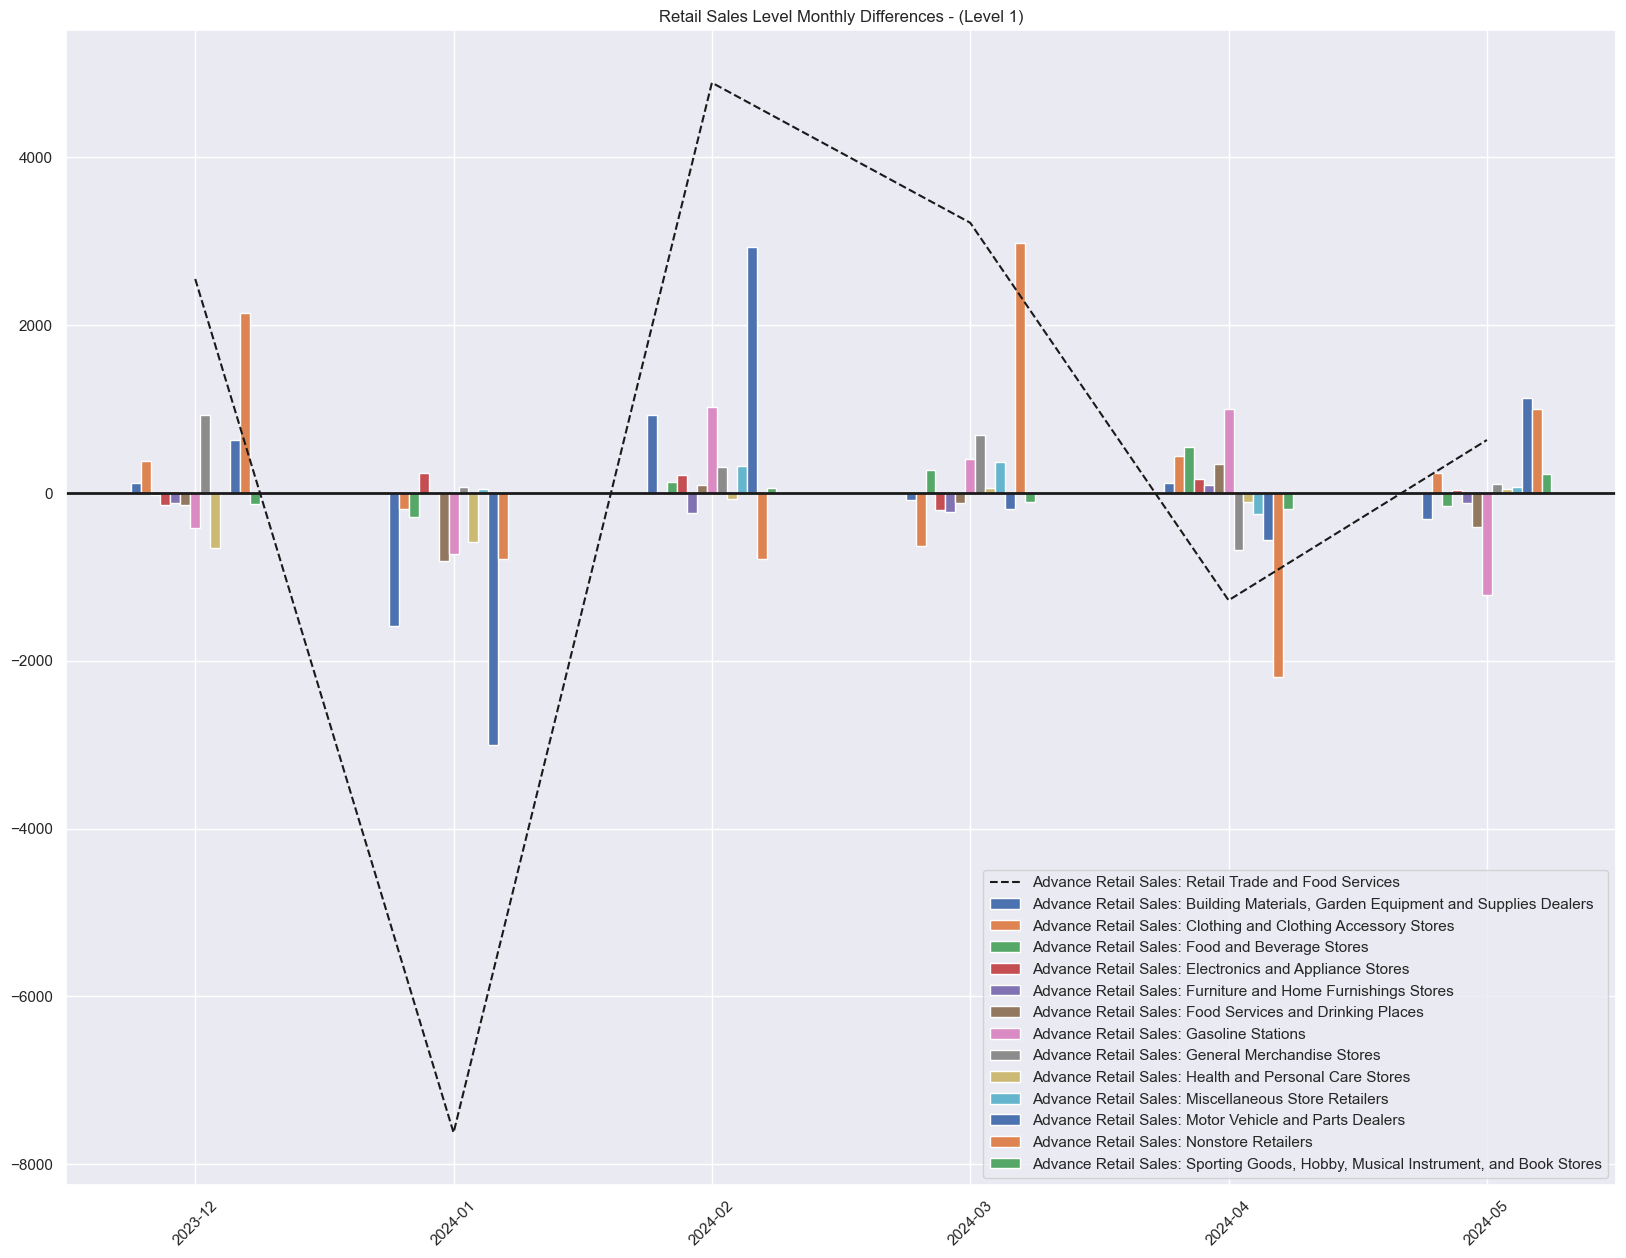

In [237]:
ax = sales_mm_diff.iloc[:,0].plot(figsize=(20,15), grid = False, title = "Retail Sales Level Monthly Differences - (Level 1)",
                                  xlabel = '',rot=45, linestyle = '--',color ='k', use_index = False)
sales_mm_diff.iloc[:,1:].plot.bar(ax=ax, stacked=False, grid=True, xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.legend(loc='best')  # upper right, lower right 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sales_mm_diff.index)))

Difference Yearly

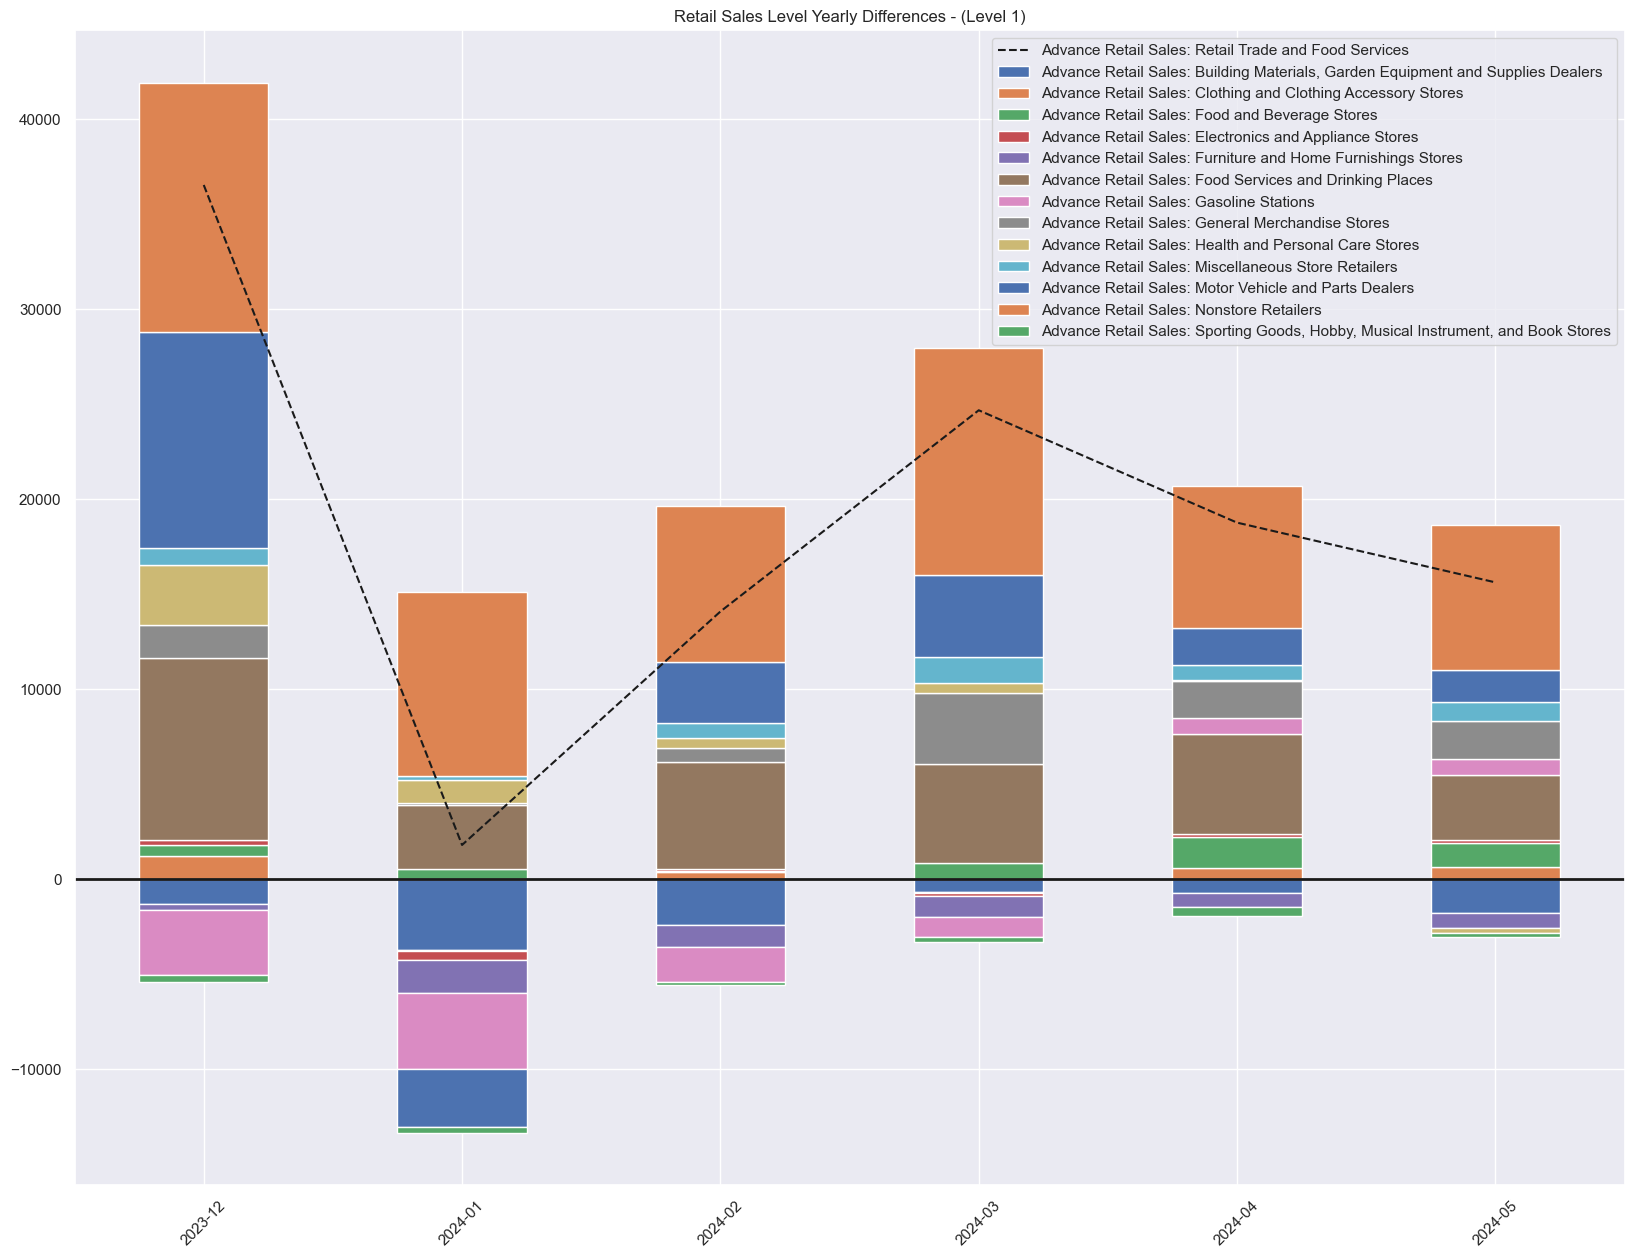

In [246]:
sales_yy_diff = all_yy_diff[['Advance Retail Sales: Retail Trade and Food Services',
    'Advance Retail Sales: Building Materials, Garden Equipment and Supplies Dealers',
       'Advance Retail Sales: Clothing and Clothing Accessory Stores',
       'Advance Retail Sales: Food and Beverage Stores',
       'Advance Retail Sales: Electronics and Appliance Stores',
       'Advance Retail Sales: Furniture and Home Furnishings Stores',
       'Advance Retail Sales: Food Services and Drinking Places',
       'Advance Retail Sales: Gasoline Stations',
       'Advance Retail Sales: General Merchandise Stores',
       'Advance Retail Sales: Health and Personal Care Stores',
       'Advance Retail Sales: Miscellaneous Store Retailers',
       'Advance Retail Sales: Motor Vehicle and Parts Dealers',
       'Advance Retail Sales: Nonstore Retailers',
       'Advance Retail Sales: Sporting Goods, Hobby, Musical Instrument, and Book Stores']]['2023-12-01':]

ax = sales_yy_diff.iloc[:,0].plot(figsize=(20,15), grid = False, title = "Retail Sales Level Yearly Differences - (Level 1)",
                                  xlabel = '',rot=45, linestyle = '--',color ='k', use_index = False)
sales_yy_diff.iloc[:,1:].plot.bar(ax=ax, stacked=True, grid=True, xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.legend(loc='best')  # upper right, lower right 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sales_yy_diff.index)))

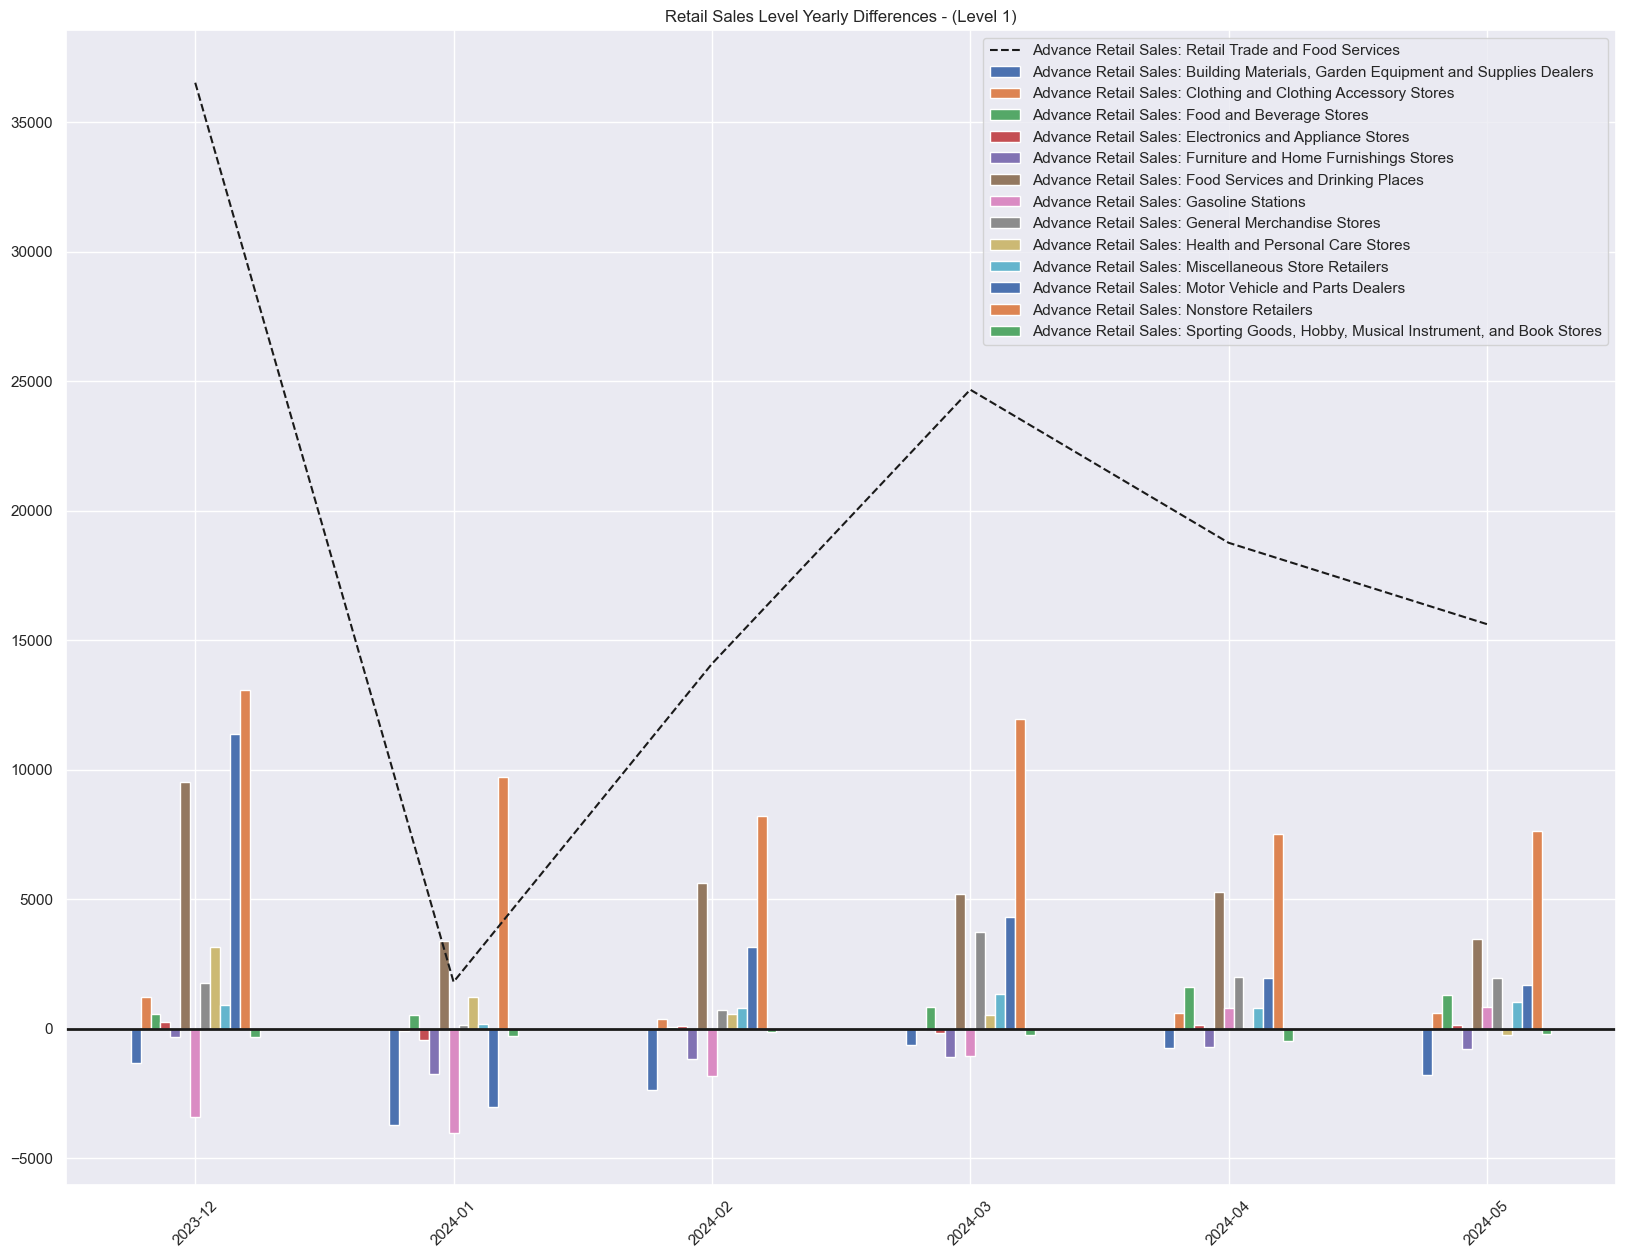

In [247]:
ax = sales_yy_diff.iloc[:,0].plot(figsize=(20,15), grid = False, title = "Retail Sales Level Yearly Differences - (Level 1)",
                                  xlabel = '',rot=45, linestyle = '--',color ='k', use_index = False)
sales_yy_diff.iloc[:,1:].plot.bar(ax=ax, stacked=False, grid=True, xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.legend(loc='best')  # upper right, lower right 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sales_yy_diff.index)))

Percent Change (y/y)

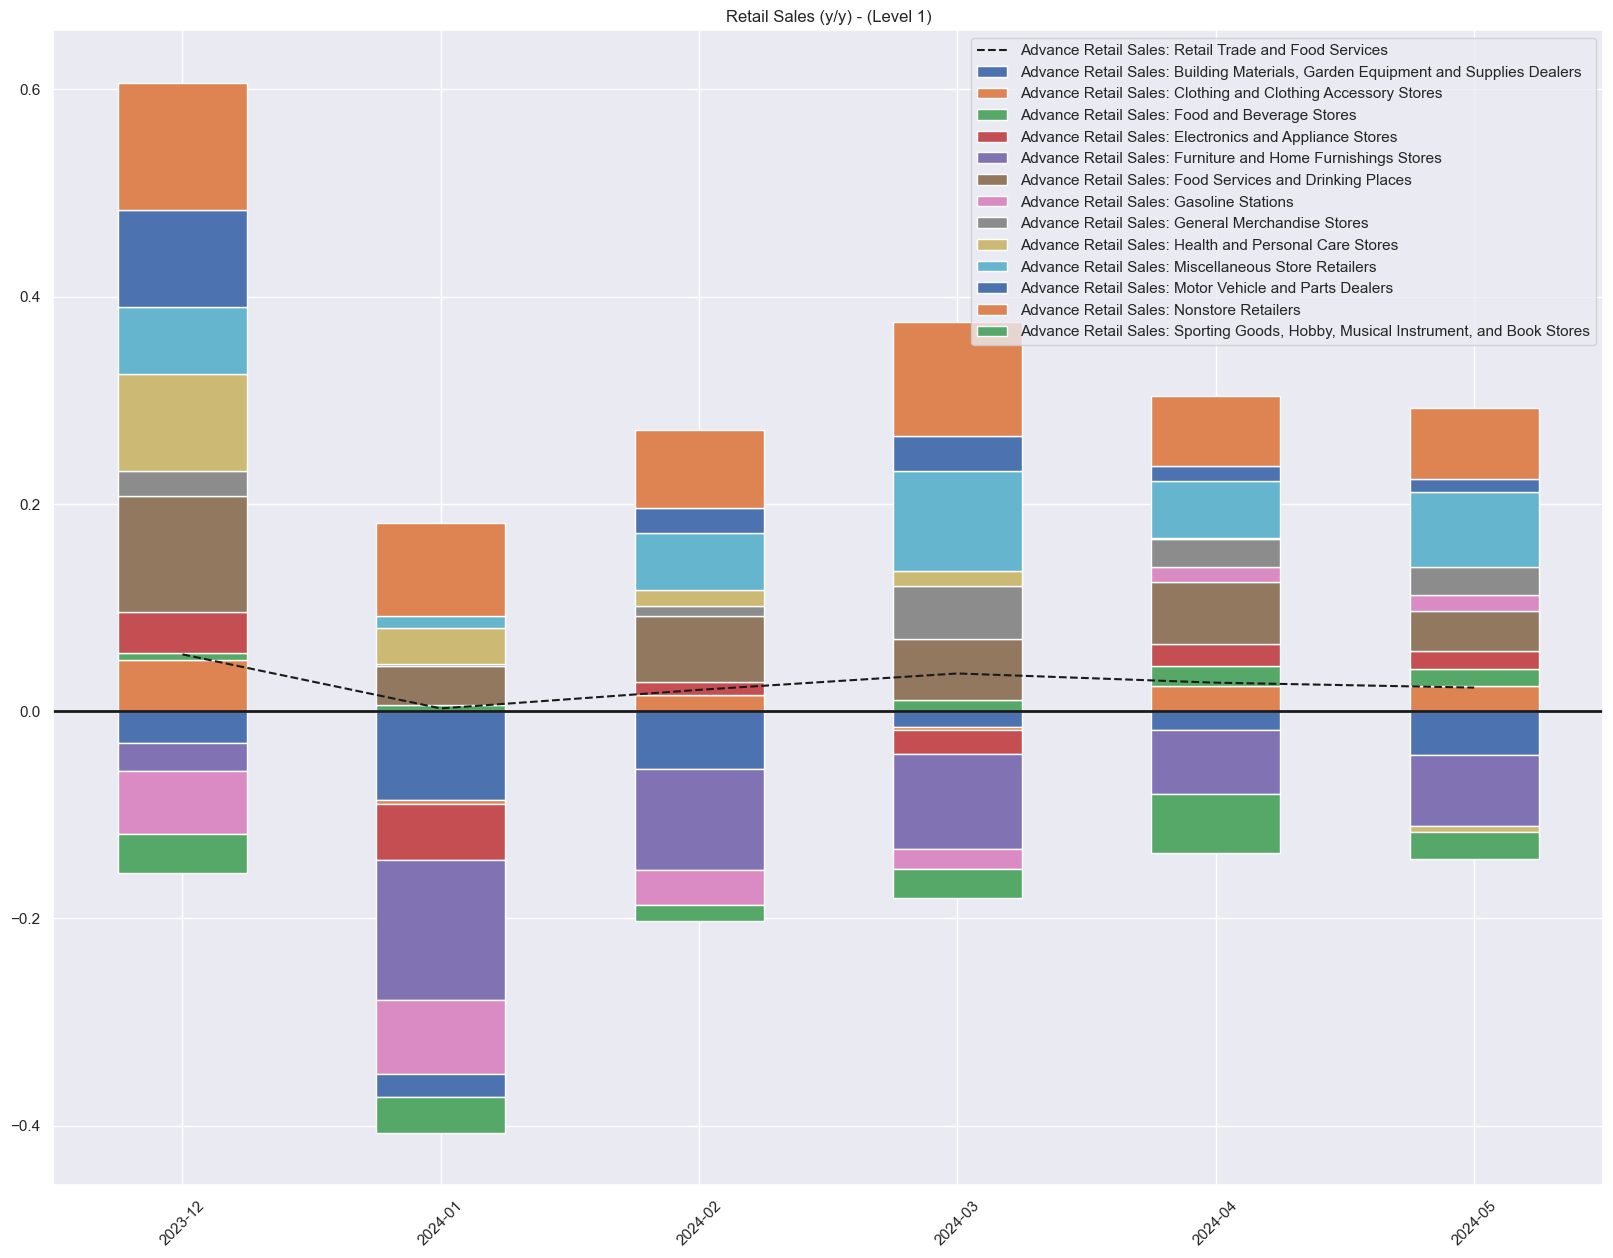

In [253]:
sales_yy = all_yy[['Advance Retail Sales: Retail Trade and Food Services',
    'Advance Retail Sales: Building Materials, Garden Equipment and Supplies Dealers',
       'Advance Retail Sales: Clothing and Clothing Accessory Stores',
       'Advance Retail Sales: Food and Beverage Stores',
       'Advance Retail Sales: Electronics and Appliance Stores',
       'Advance Retail Sales: Furniture and Home Furnishings Stores',
       'Advance Retail Sales: Food Services and Drinking Places',
       'Advance Retail Sales: Gasoline Stations',
       'Advance Retail Sales: General Merchandise Stores',
       'Advance Retail Sales: Health and Personal Care Stores',
       'Advance Retail Sales: Miscellaneous Store Retailers',
       'Advance Retail Sales: Motor Vehicle and Parts Dealers',
       'Advance Retail Sales: Nonstore Retailers',
       'Advance Retail Sales: Sporting Goods, Hobby, Musical Instrument, and Book Stores']]['2023-12-01':]

ax = sales_yy.iloc[:,0].plot(figsize=(20,15), grid = False, title = "Retail Sales (y/y) - (Level 1)",
                                  xlabel = '',rot=45, linestyle = '--',color ='k', use_index = False)
sales_yy.iloc[:,1:].plot.bar(ax=ax, stacked=True, grid=True, xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.legend(loc='best')  # upper right, lower right 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sales_yy.index)))

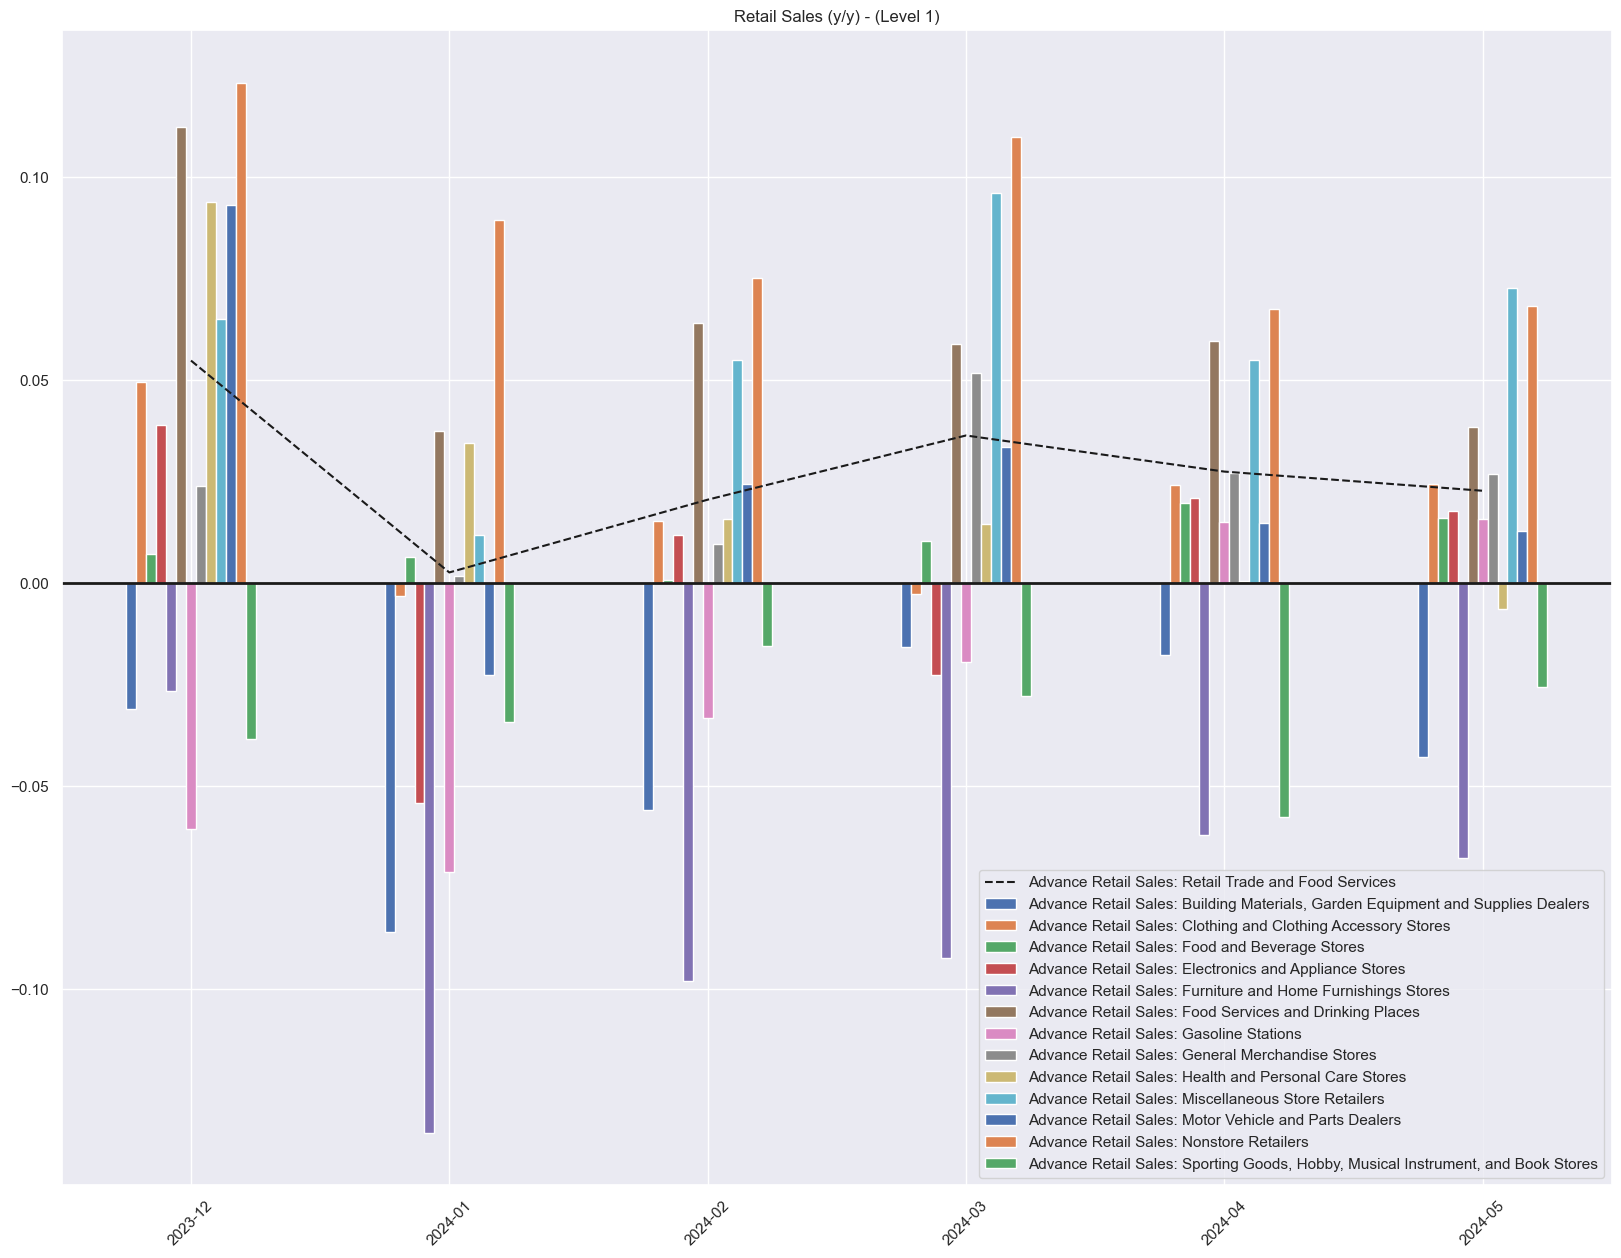

In [254]:
ax = sales_yy.iloc[:,0].plot(figsize=(20,15), grid = False, title = "Retail Sales (y/y) - (Level 1)",
                                  xlabel = '',rot=45, linestyle = '--',color ='k', use_index = False)
sales_yy.iloc[:,1:].plot.bar(ax=ax, stacked=False, grid=True, xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.legend(loc='best')  # upper right, lower right 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sales_yy.index)))

Percent Change (m/m)

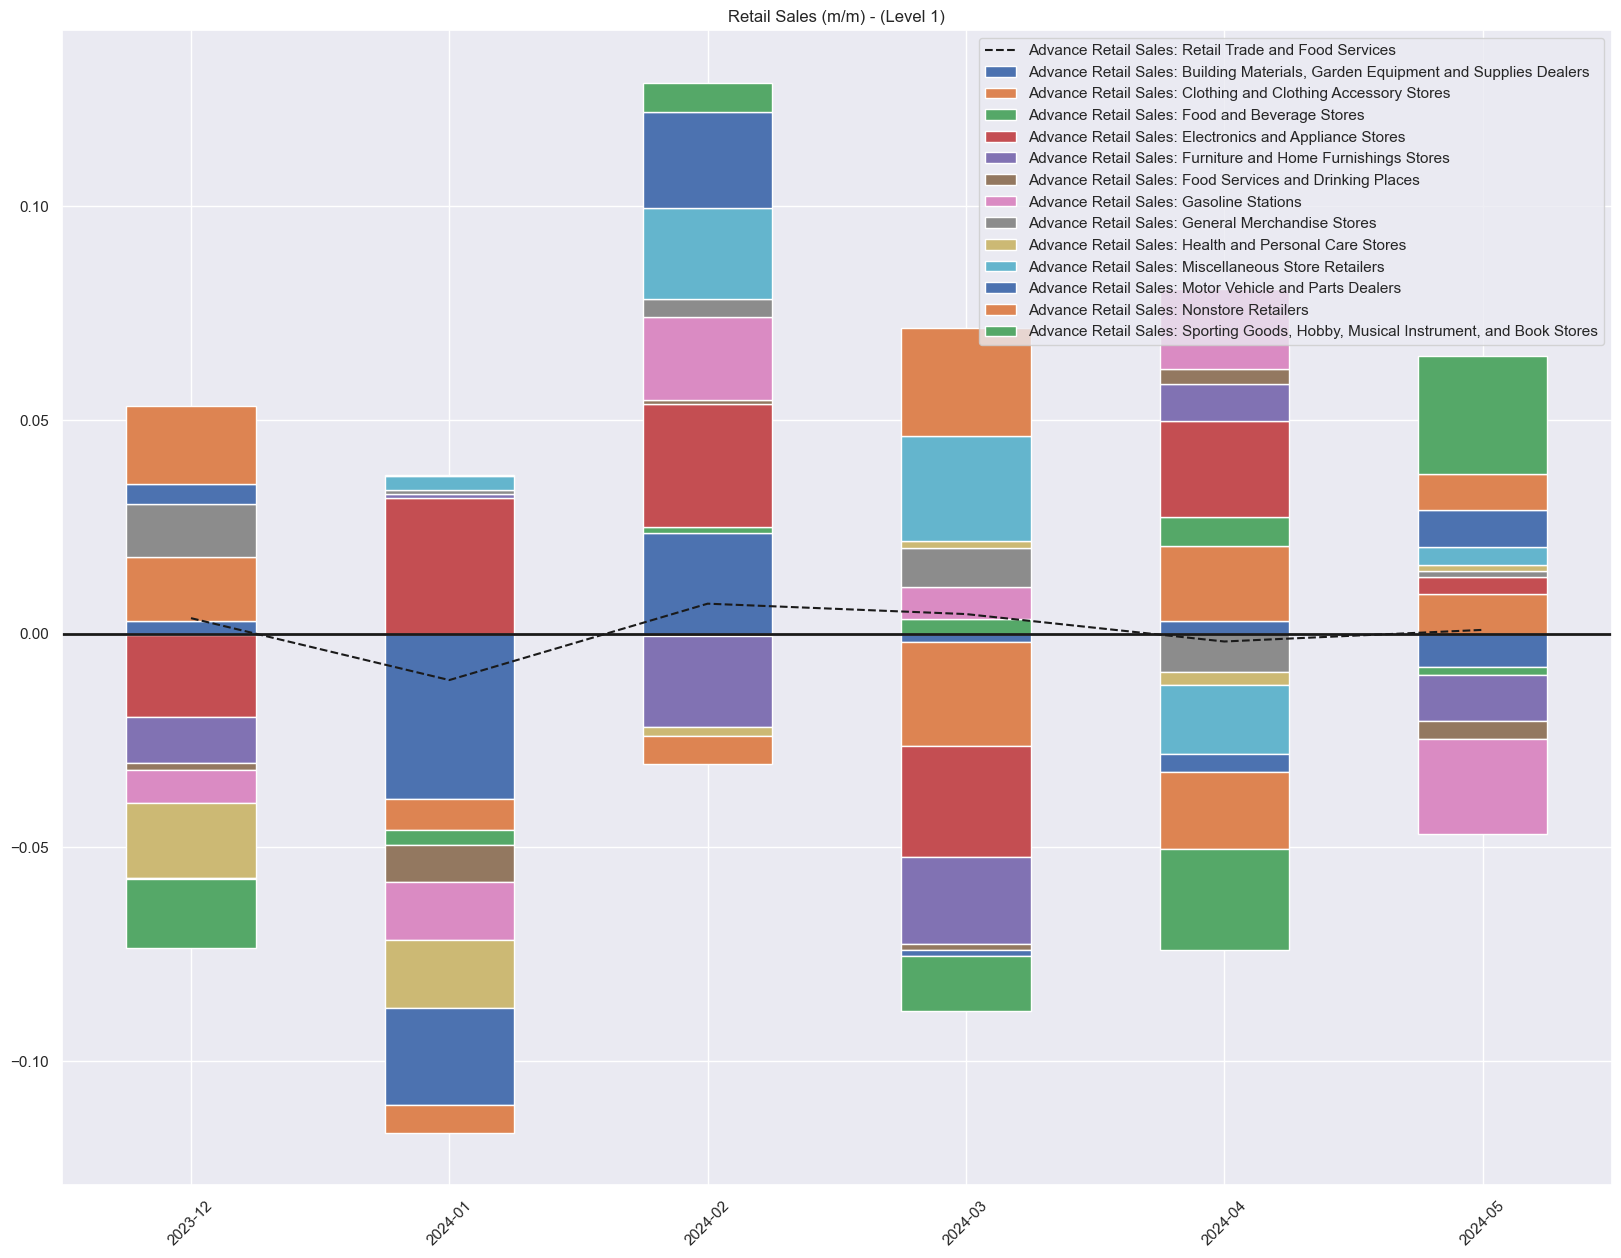

In [251]:
sales_mm = all_mm[['Advance Retail Sales: Retail Trade and Food Services',
    'Advance Retail Sales: Building Materials, Garden Equipment and Supplies Dealers',
       'Advance Retail Sales: Clothing and Clothing Accessory Stores',
       'Advance Retail Sales: Food and Beverage Stores',
       'Advance Retail Sales: Electronics and Appliance Stores',
       'Advance Retail Sales: Furniture and Home Furnishings Stores',
       'Advance Retail Sales: Food Services and Drinking Places',
       'Advance Retail Sales: Gasoline Stations',
       'Advance Retail Sales: General Merchandise Stores',
       'Advance Retail Sales: Health and Personal Care Stores',
       'Advance Retail Sales: Miscellaneous Store Retailers',
       'Advance Retail Sales: Motor Vehicle and Parts Dealers',
       'Advance Retail Sales: Nonstore Retailers',
       'Advance Retail Sales: Sporting Goods, Hobby, Musical Instrument, and Book Stores']]['2023-12-01':]

ax = sales_mm.iloc[:,0].plot(figsize=(20,15), grid = False, title = "Retail Sales (m/m) - (Level 1)",
                                  xlabel = '',rot=45, linestyle = '--',color ='k', use_index = False)
sales_mm.iloc[:,1:].plot.bar(ax=ax, stacked=True, grid=True, xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.legend(loc='best')  # upper right, lower right 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sales_mm.index)))

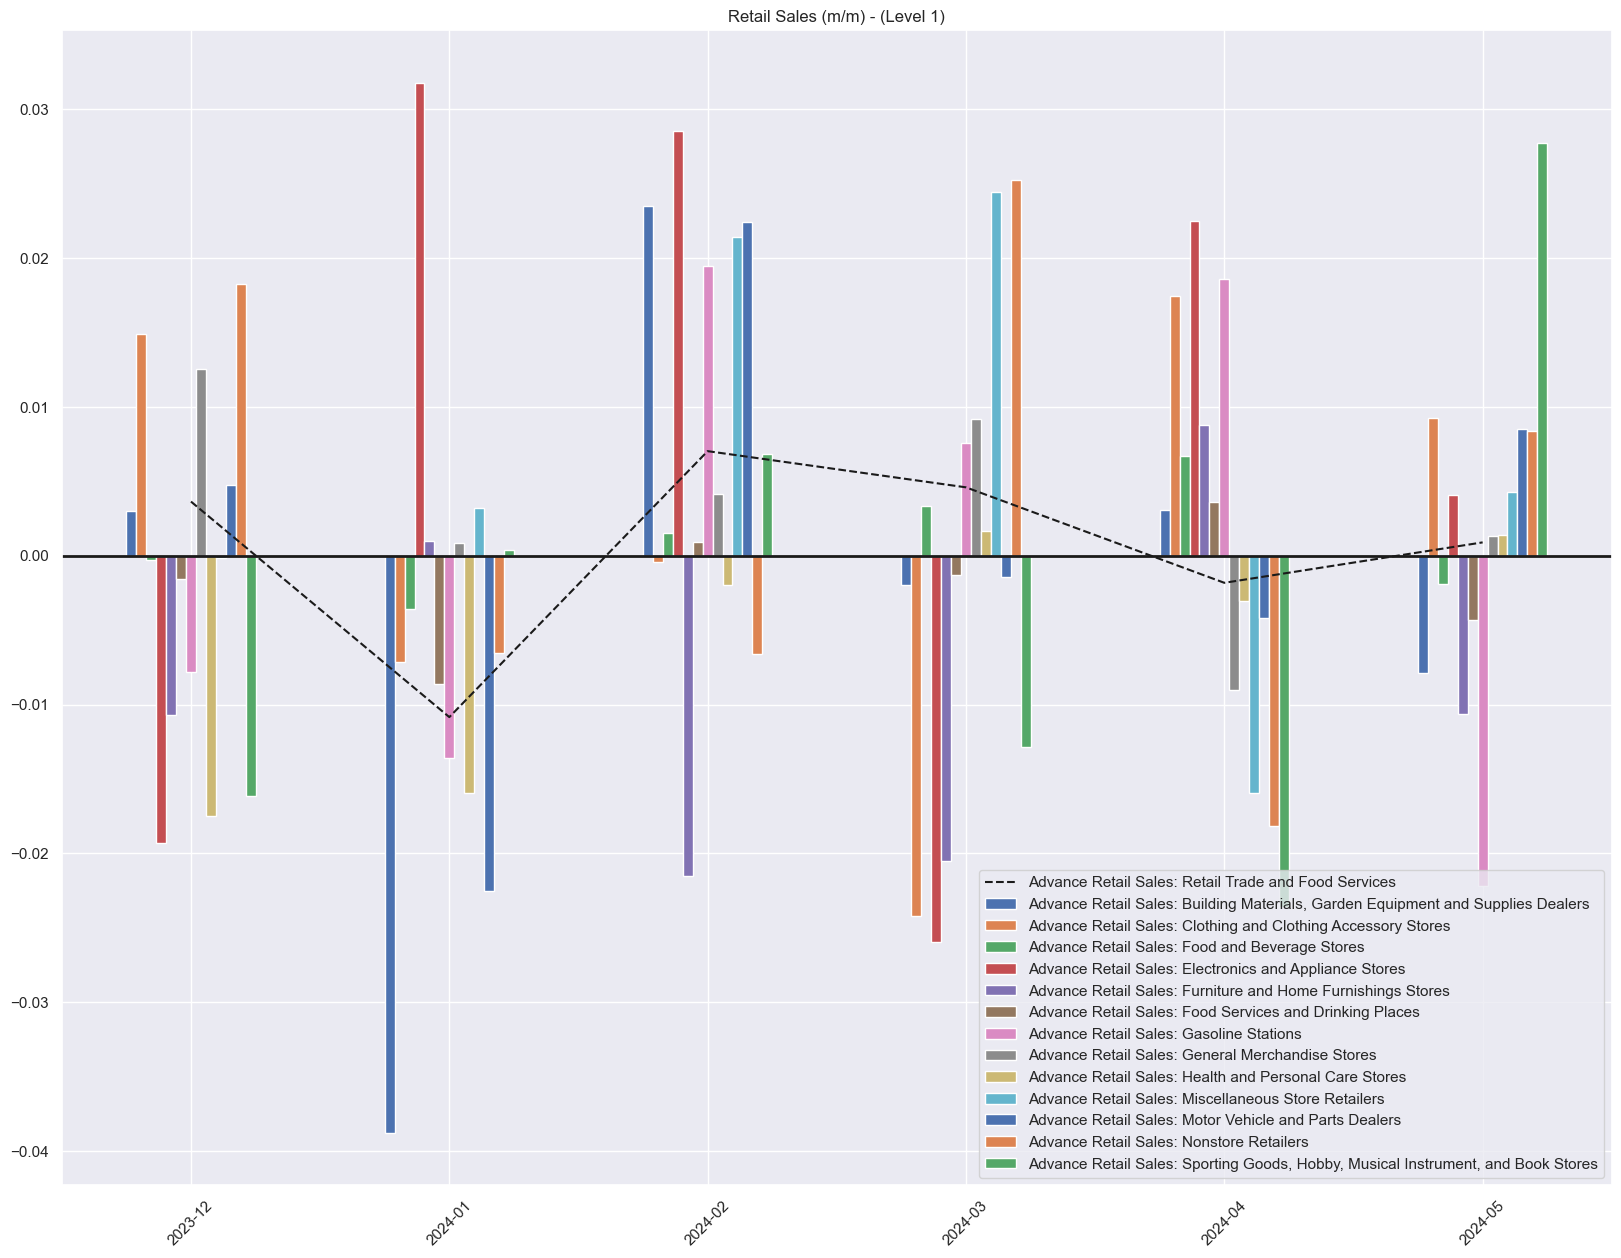

In [252]:
ax = sales_mm.iloc[:,0].plot(figsize=(20,15), grid = False, title = "Retail Sales (m/m) - (Level 1)",
                                  xlabel = '',rot=45, linestyle = '--',color ='k', use_index = False)
sales_mm.iloc[:,1:].plot.bar(ax=ax, stacked=False, grid=True, xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.legend(loc='best')  # upper right, lower right 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sales_mm.index)))

Core Group - Remove Noise (Volatile Components)

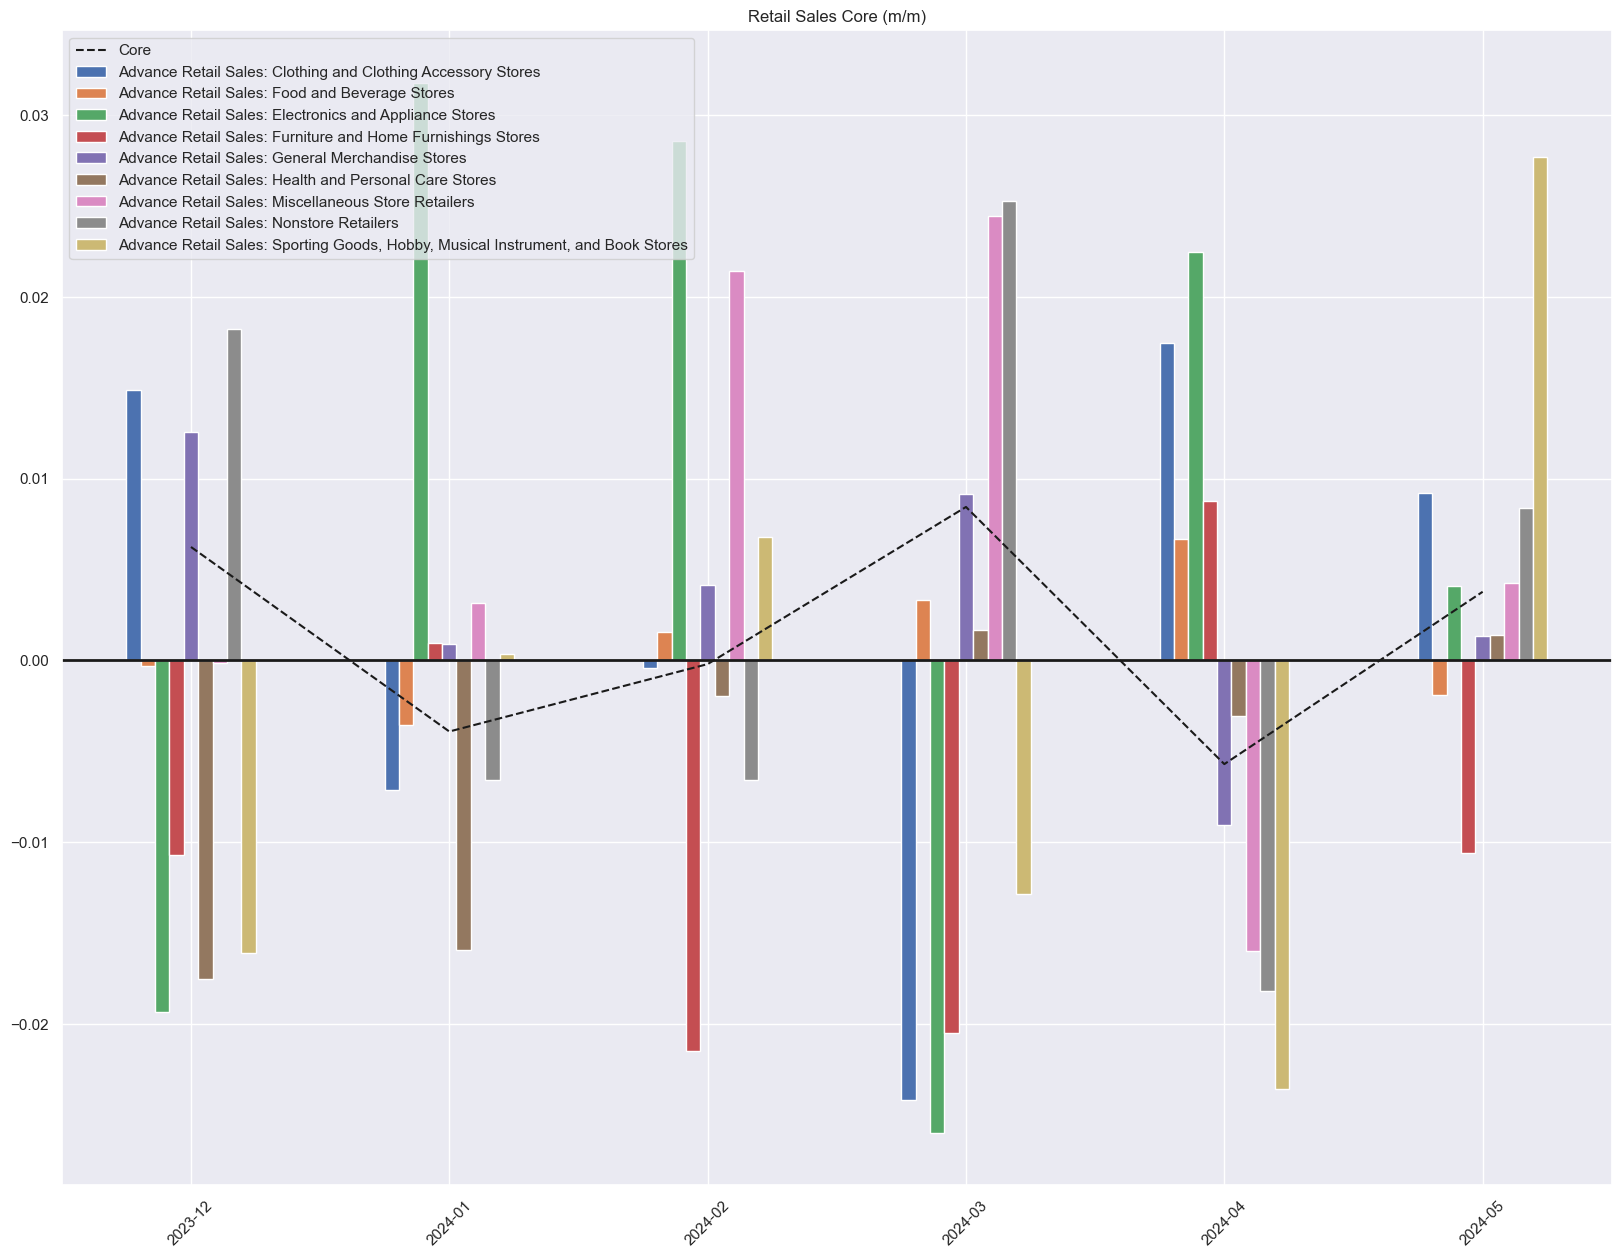

In [262]:
core = all[[
       'Advance Retail Sales: Clothing and Clothing Accessory Stores',
       'Advance Retail Sales: Food and Beverage Stores',
       'Advance Retail Sales: Electronics and Appliance Stores',
       'Advance Retail Sales: Furniture and Home Furnishings Stores',
       'Advance Retail Sales: General Merchandise Stores',
       'Advance Retail Sales: Health and Personal Care Stores',
       'Advance Retail Sales: Miscellaneous Store Retailers',
       'Advance Retail Sales: Nonstore Retailers',
       'Advance Retail Sales: Sporting Goods, Hobby, Musical Instrument, and Book Stores']] # 'Advance Retail Sales: Building Materials, Garden Equipment and Supplies Dealers',
core['Core'] = core.sum(axis=1)
core = core.pct_change()
core_recent = core[["Core",
       'Advance Retail Sales: Clothing and Clothing Accessory Stores',
       'Advance Retail Sales: Food and Beverage Stores',
       'Advance Retail Sales: Electronics and Appliance Stores',
       'Advance Retail Sales: Furniture and Home Furnishings Stores',
       'Advance Retail Sales: General Merchandise Stores',
       'Advance Retail Sales: Health and Personal Care Stores',
       'Advance Retail Sales: Miscellaneous Store Retailers',
       'Advance Retail Sales: Nonstore Retailers',
       'Advance Retail Sales: Sporting Goods, Hobby, Musical Instrument, and Book Stores']]["2023-12-01":] # 'Advance Retail Sales: Building Materials, Garden Equipment and Supplies Dealers',
ax = core_recent.iloc[:,0].plot(figsize=(20,15), grid = False, title = "Retail Sales Core (m/m)",
                                  xlabel = '',rot=45, linestyle = '--',color ='k', use_index = False)
core_recent.iloc[:,1:].plot.bar(ax=ax, stacked=False, grid=True, xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.legend(loc='best')  # upper right, lower right 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, core_recent.index)))

YoY Percent Change

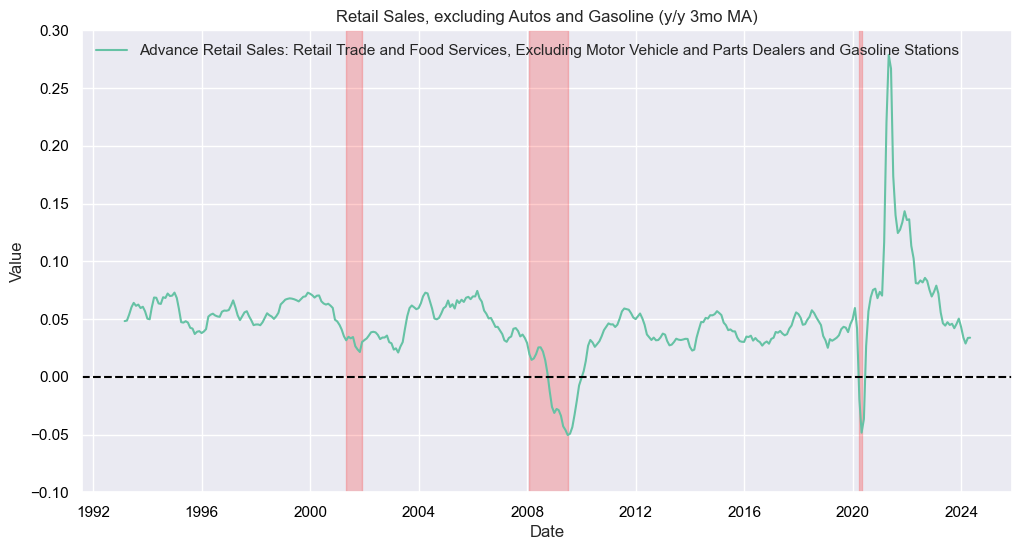

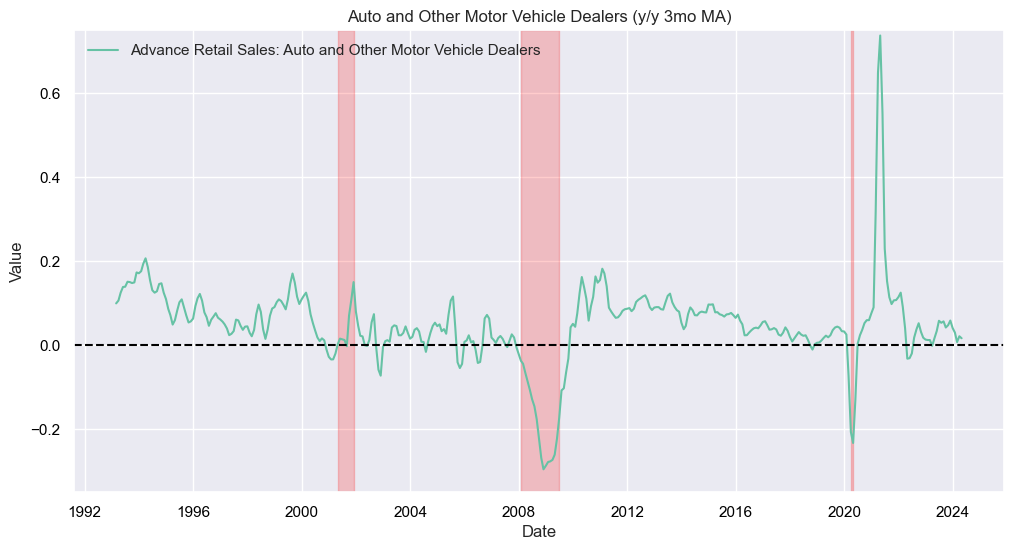

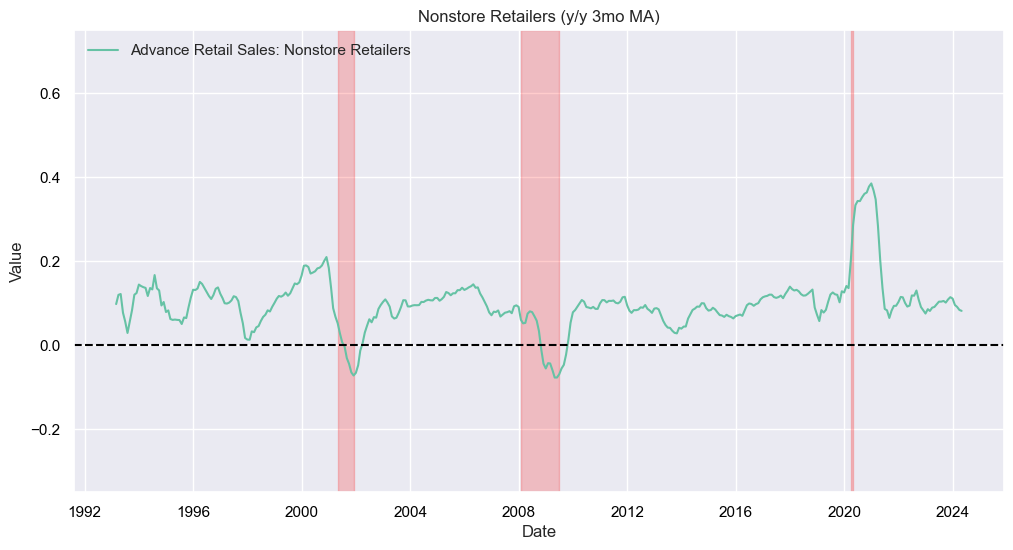

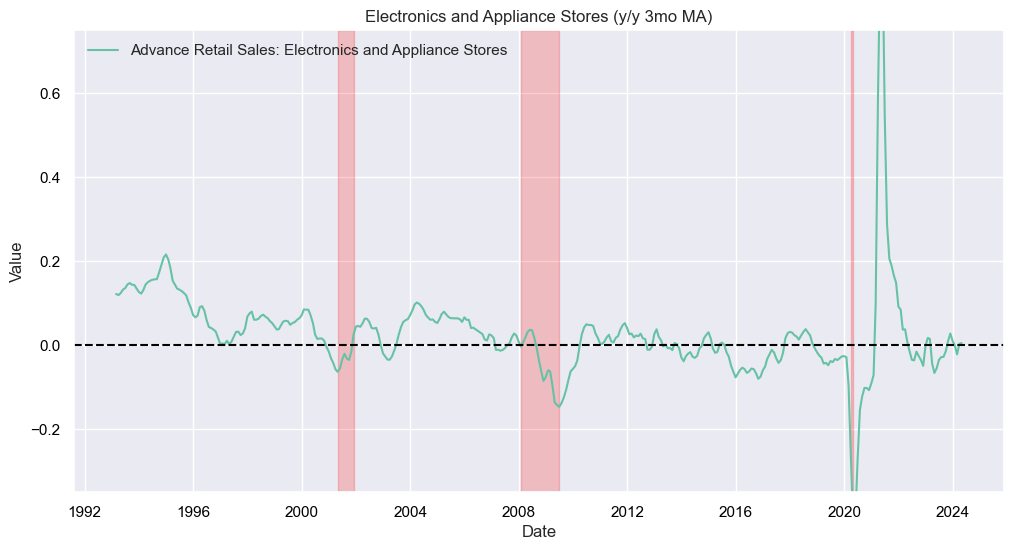

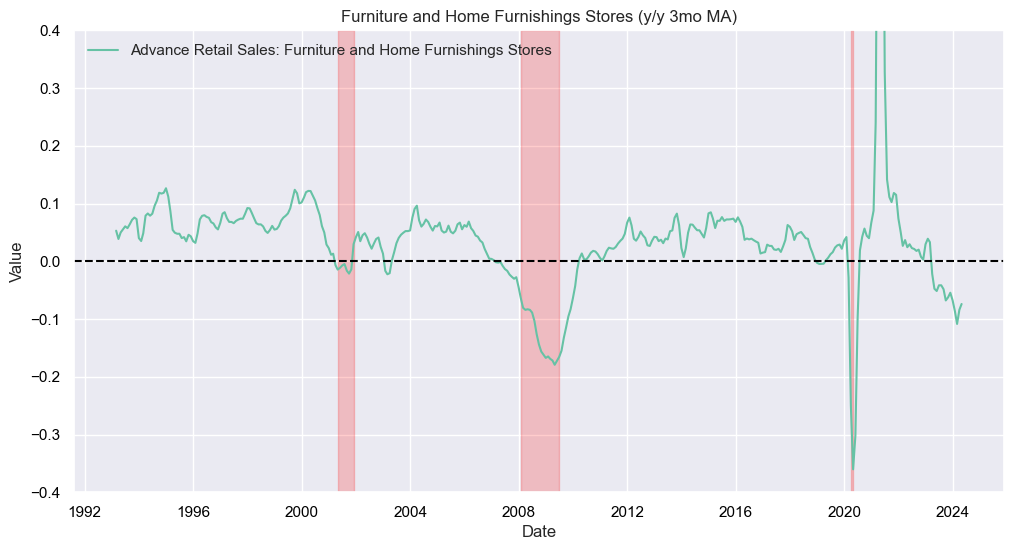

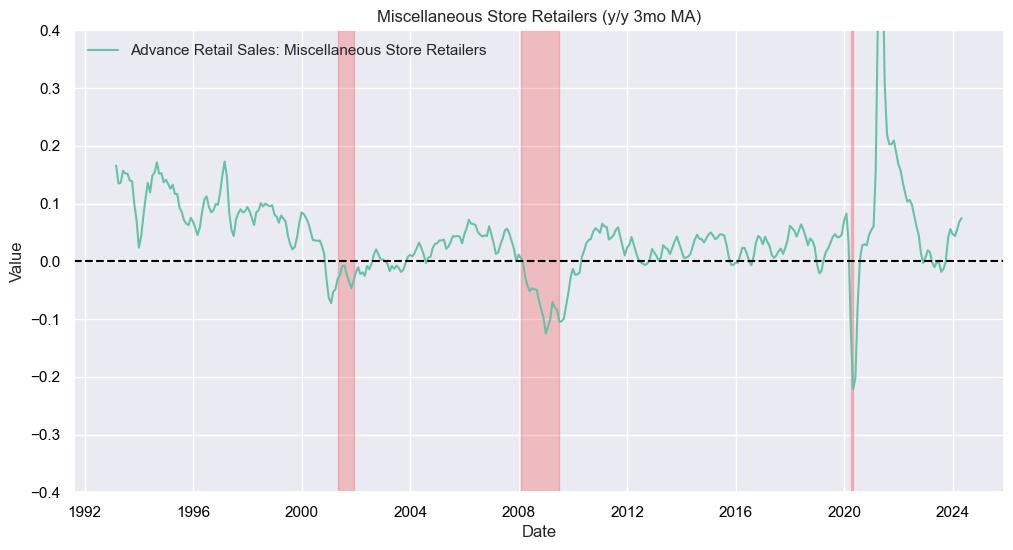

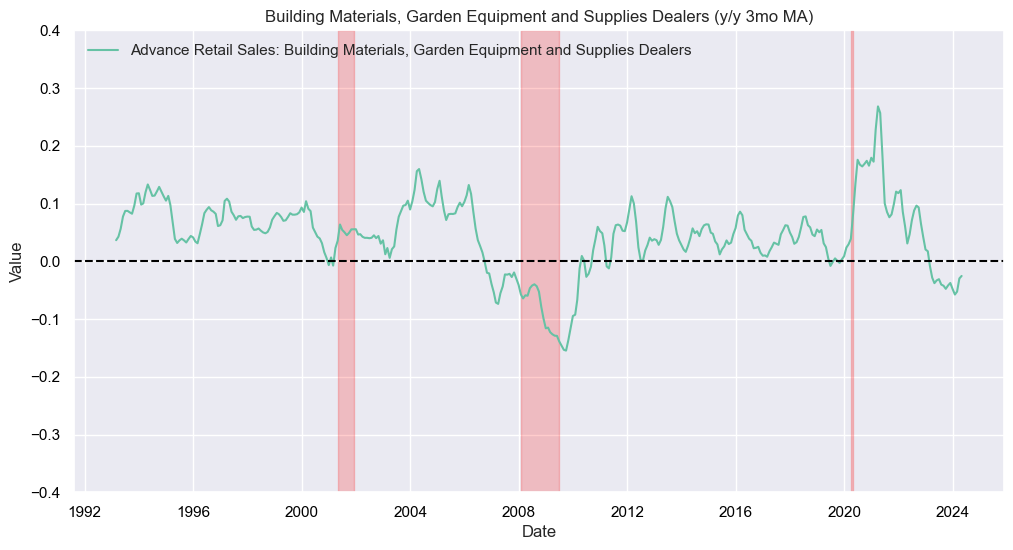

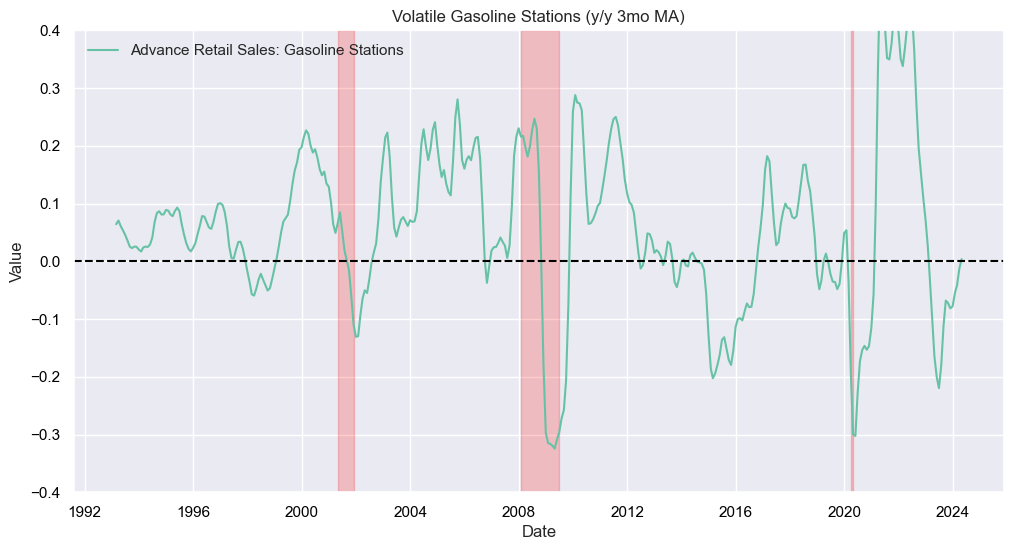

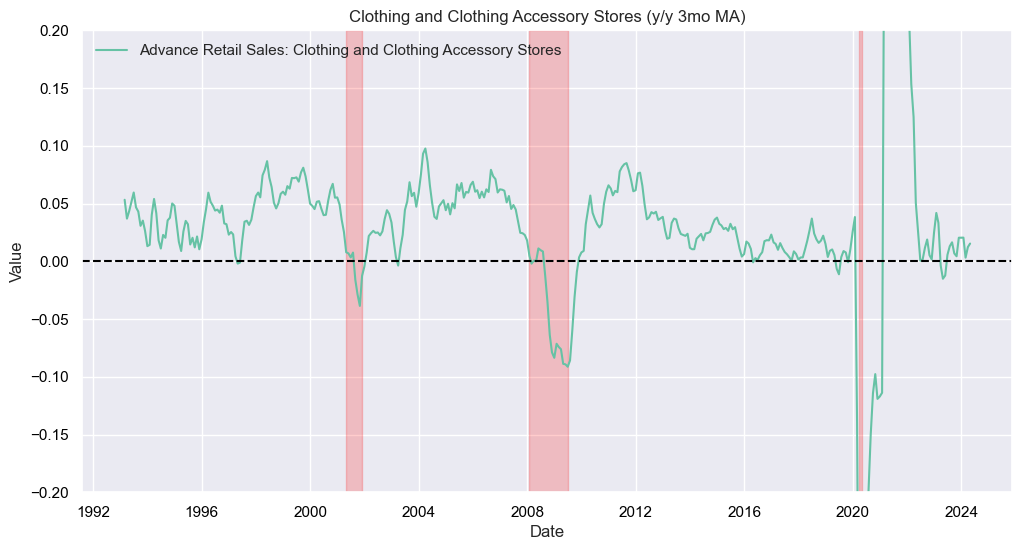

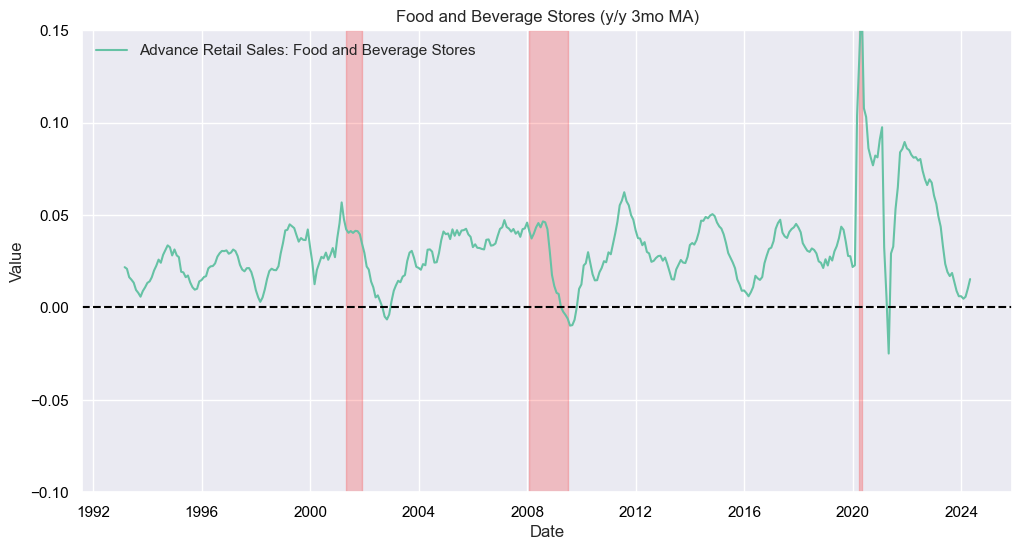

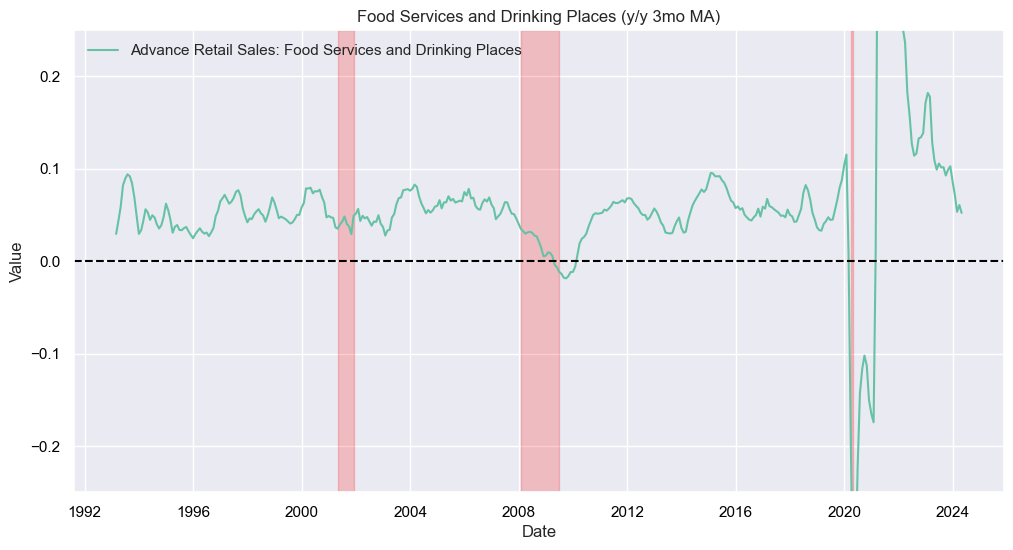

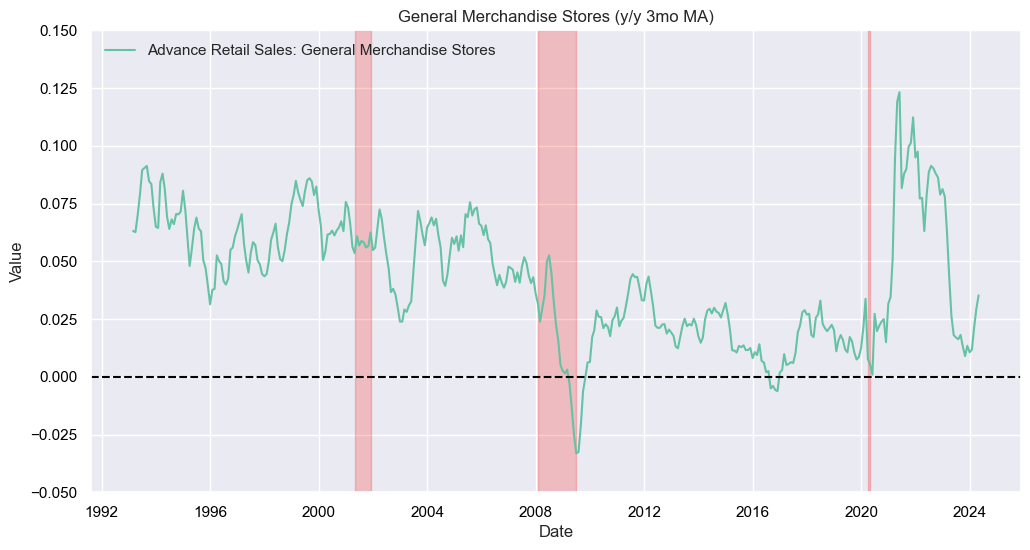

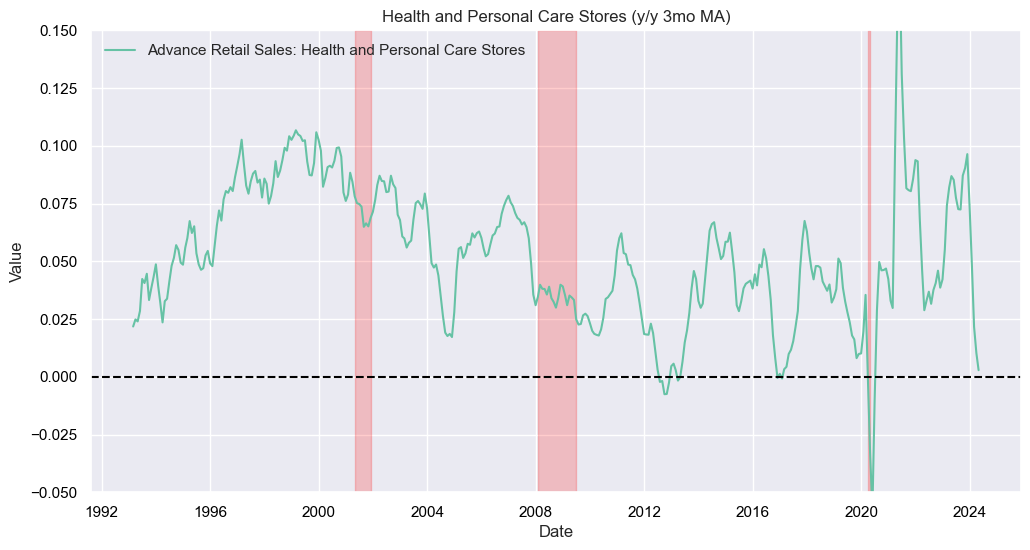

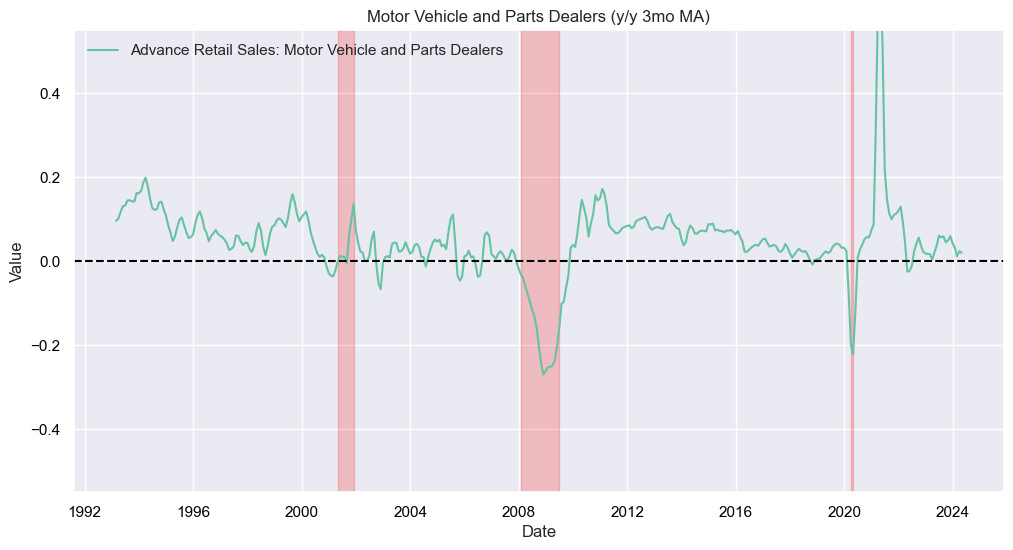

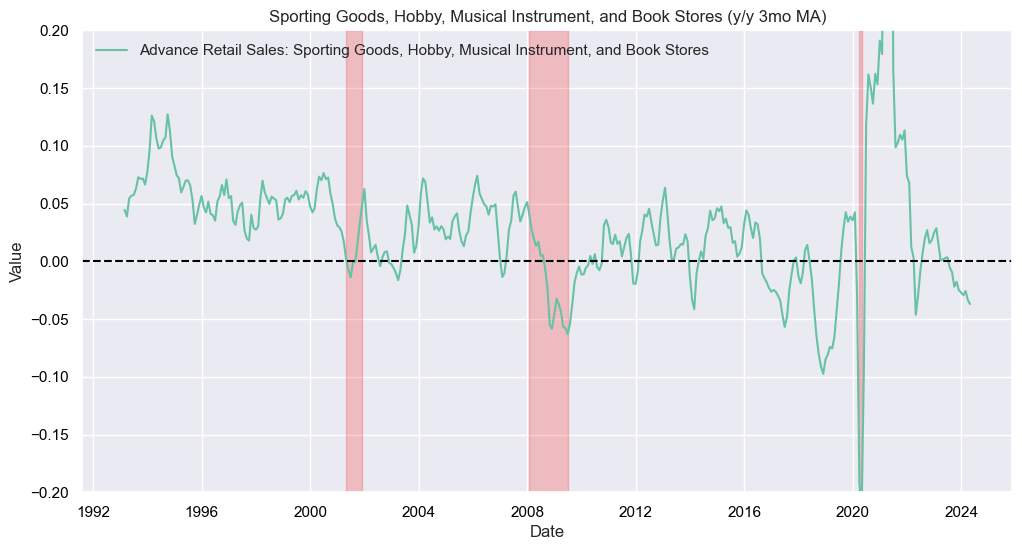

In [99]:
eco_plot(all_yy[["Advance Retail Sales: Retail Trade and Food Services, Excluding Motor Vehicle and Parts Dealers and Gasoline Stations"]].rolling(3).mean(), start, 
         end, 'Retail Sales, excluding Autos and Gasoline (y/y 3mo MA)', -.1, .3, 00, 100, plot=True, save_fig=False)
eco_plot(all_yy[["Advance Retail Sales: Auto and Other Motor Vehicle Dealers"]].rolling(3).mean(), start, 
         end, 'Auto and Other Motor Vehicle Dealers (y/y 3mo MA)', -.35, .75, 00, 100, plot=True, save_fig=False)
eco_plot(all_yy[["Advance Retail Sales: Nonstore Retailers"]].rolling(3).mean(), start, 
         end, 'Nonstore Retailers (y/y 3mo MA)', -.35, .75, 00, 100, plot=True, save_fig=False)
eco_plot(all_yy[["Advance Retail Sales: Electronics and Appliance Stores"]].rolling(3).mean(), start, 
         end, 'Electronics and Appliance Stores (y/y 3mo MA)', -.35, .75, 00, 100, plot=True, save_fig=False)
eco_plot(all_yy[["Advance Retail Sales: Furniture and Home Furnishings Stores"]].rolling(3).mean(), start, 
         end, 'Furniture and Home Furnishings Stores (y/y 3mo MA)', -.4, .4, 00, 100, plot=True, save_fig=False)
eco_plot(all_yy[["Advance Retail Sales: Miscellaneous Store Retailers"]].rolling(3).mean(), start, 
         end, 'Miscellaneous Store Retailers (y/y 3mo MA)', -.4, .4, 00, 100, plot=True, save_fig=False)
eco_plot(all_yy[["Advance Retail Sales: Building Materials, Garden Equipment and Supplies Dealers"]].rolling(3).mean(), start, 
         end, 'Building Materials, Garden Equipment and Supplies Dealers (y/y 3mo MA)', -.4, .4, 00, 100, plot=True, save_fig=False)
eco_plot(all_yy[["Advance Retail Sales: Gasoline Stations"]].rolling(3).mean(), start, 
         end, 'Gasoline Stations (y/y 3mo MA)', -.4, .4, 00, 100, plot=True, save_fig=False)
eco_plot(all_yy[["Advance Retail Sales: Clothing and Clothing Accessory Stores"]].rolling(3).mean(), start, 
         end, 'Clothing and Clothing Accessory Stores (y/y 3mo MA)', -.2, .2, 00, 100, plot=True, save_fig=False)
eco_plot(all_yy[["Advance Retail Sales: Food and Beverage Stores"]].rolling(3).mean(), start, 
         end, 'Food and Beverage Stores (y/y 3mo MA)', -.1, .15, 00, 100, plot=True, save_fig=False)
eco_plot(all_yy[["Advance Retail Sales: Food Services and Drinking Places"]].rolling(3).mean(), start, 
         end, 'Food Services and Drinking Places (y/y 3mo MA)', -.25, .25, 00, 100, plot=True, save_fig=False)
eco_plot(all_yy[["Advance Retail Sales: General Merchandise Stores"]].rolling(3).mean(), start, 
         end, 'General Merchandise Stores (y/y 3mo MA)', -.05, .15, 00, 100, plot=True, save_fig=False)
eco_plot(all_yy[["Advance Retail Sales: Health and Personal Care Stores"]].rolling(3).mean(), start, 
         end, 'Health and Personal Care Stores (y/y 3mo MA)', -.05, .15, 00, 100, plot=True, save_fig=False)
eco_plot(all_yy[["Advance Retail Sales: Motor Vehicle and Parts Dealers"]].rolling(3).mean(), start, 
         end, 'Motor Vehicle and Parts Dealers (y/y 3mo MA)', -.55, .55, 00, 100, plot=True, save_fig=False)
eco_plot(all_yy[["Advance Retail Sales: Sporting Goods, Hobby, Musical Instrument, and Book Stores"]].rolling(3).mean(), start, 
         end, 'Sporting Goods, Hobby, Musical Instrument, and Book Stores (y/y 3mo MA)', -.2, .2, 00, 100, plot=True, save_fig=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


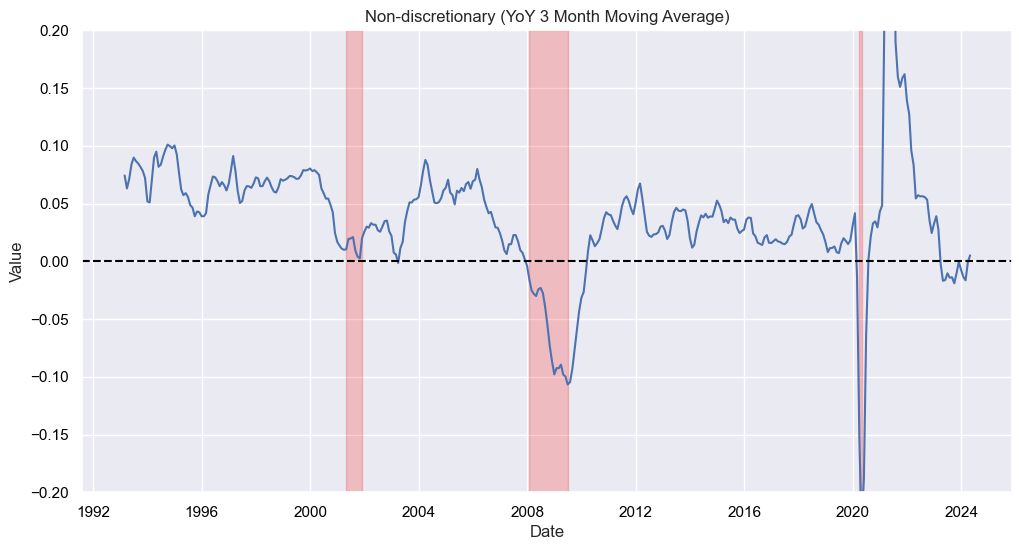

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


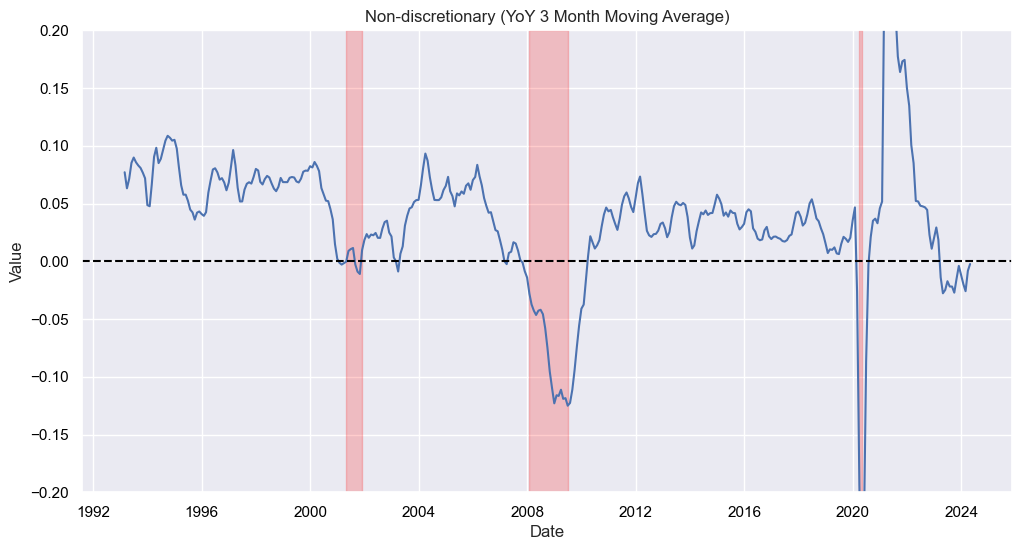

In [342]:
nondiscretionary = all_yy[["Advance Retail Sales: Building Materials, Garden Equipment and Supplies Dealers","Advance Retail Sales: Clothing and Clothing Accessory Stores",
        "Advance Retail Sales: Furniture and Home Furnishings Stores","Advance Retail Sales: Miscellaneous Store Retailers",
        "Advance Retail Sales: General Merchandise Stores"]].rolling(3).mean().mean(axis=1)
eco_plot(nondiscretionary, start, end, 'Non-discretionary (YoY 3 Month Moving Average)', -.2, .2, 00, 100, plot=True, save_fig=False)
nondiscretionary = all_yy[["Advance Retail Sales: Building Materials, Garden Equipment and Supplies Dealers","Advance Retail Sales: Clothing and Clothing Accessory Stores",
        "Advance Retail Sales: Furniture and Home Furnishings Stores","Advance Retail Sales: Miscellaneous Store Retailers"]].rolling(3).mean().mean(axis=1)
eco_plot(nondiscretionary, start, end, 'Non-discretionary (YoY 3 Month Moving Average)', -.2, .2, 00, 100, plot=True, save_fig=False)

2 Year Differences

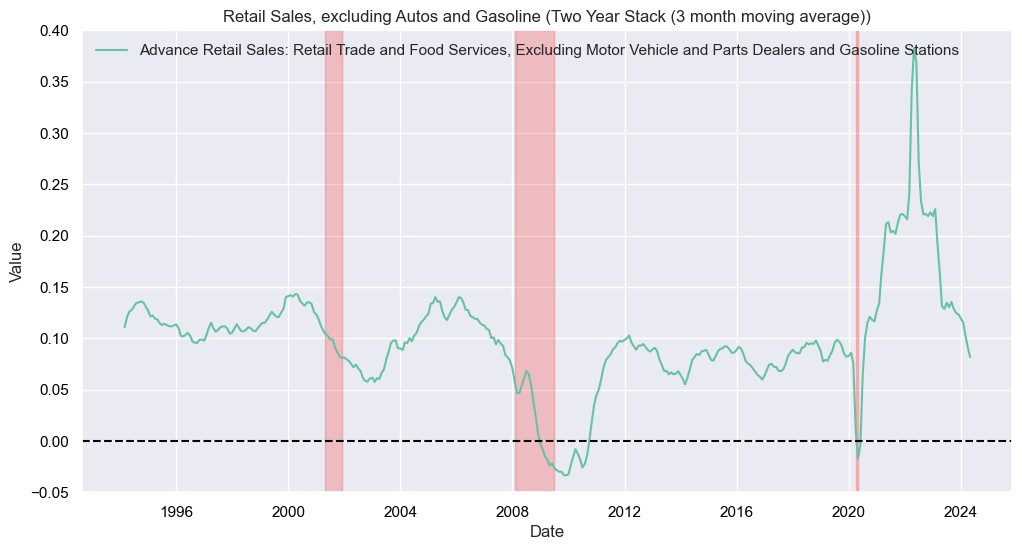

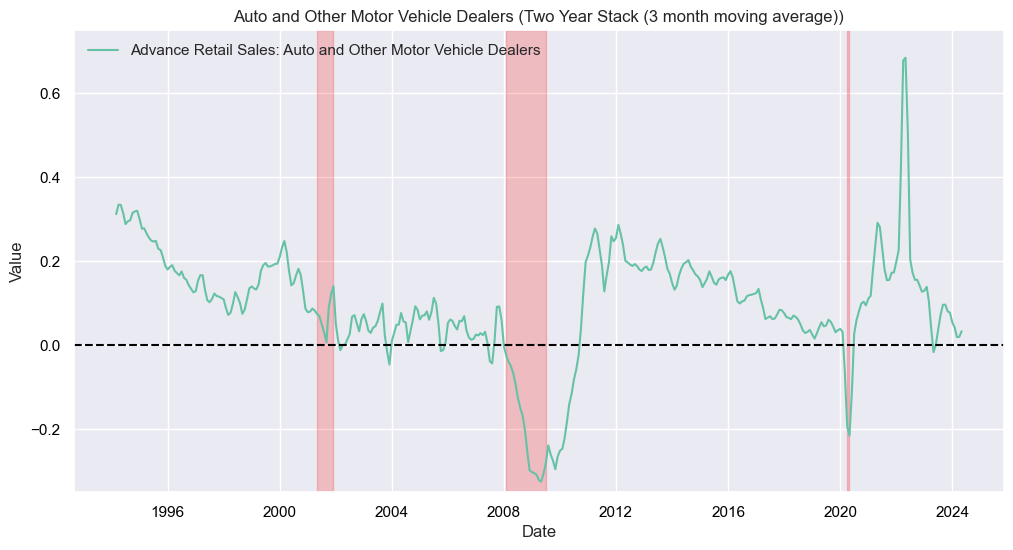

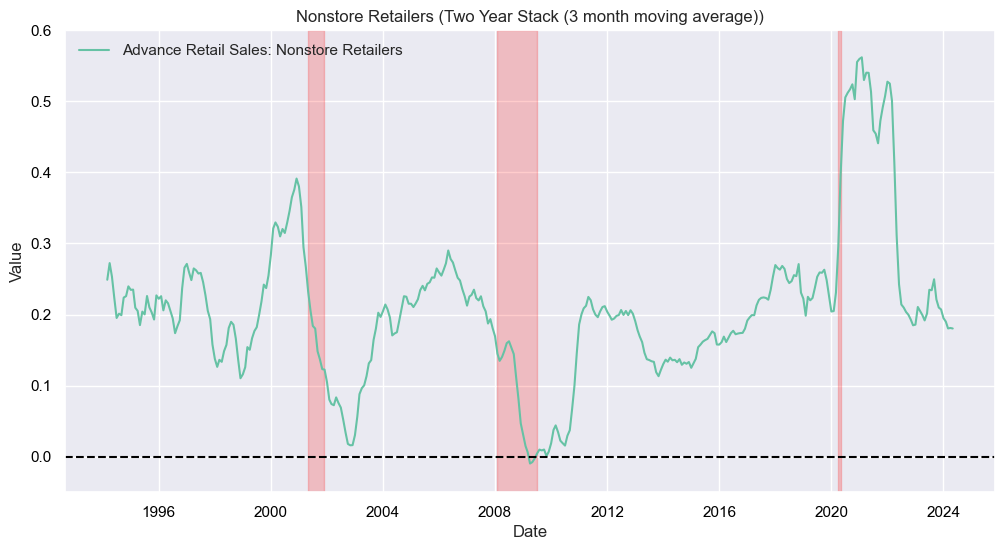

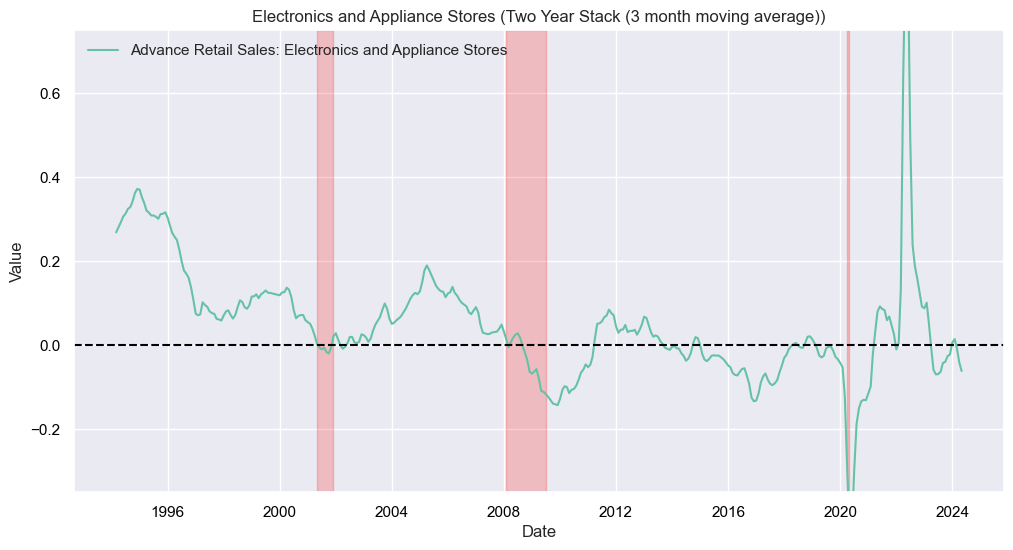

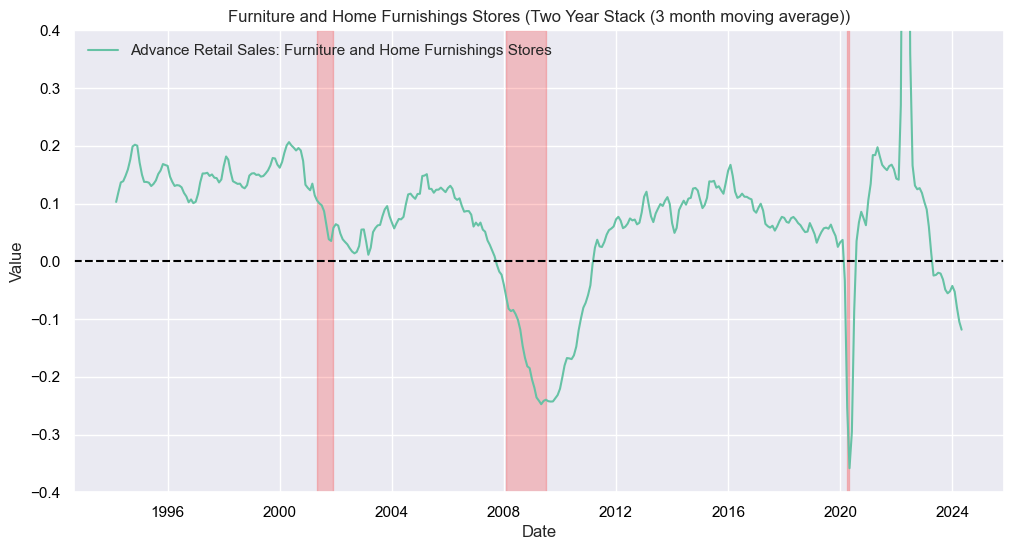

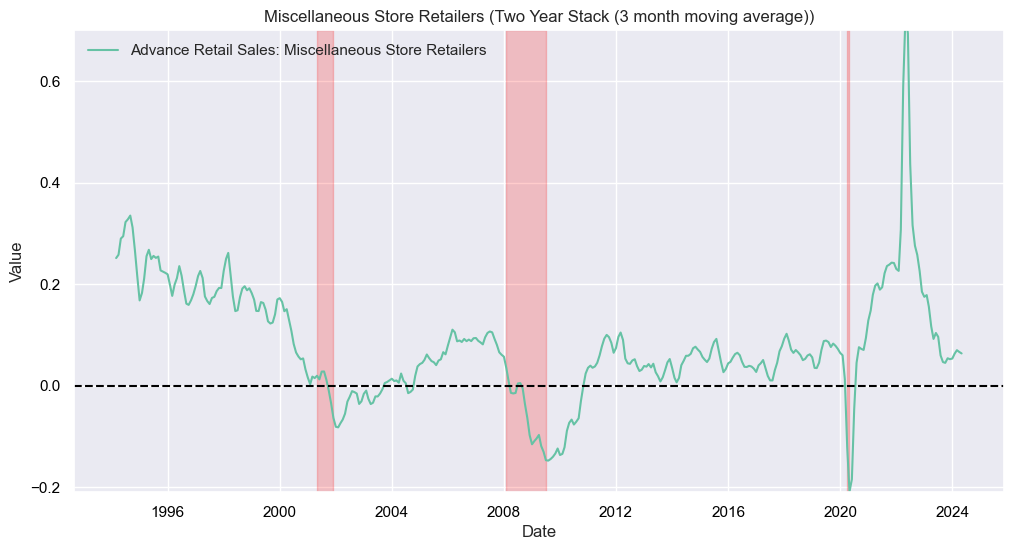

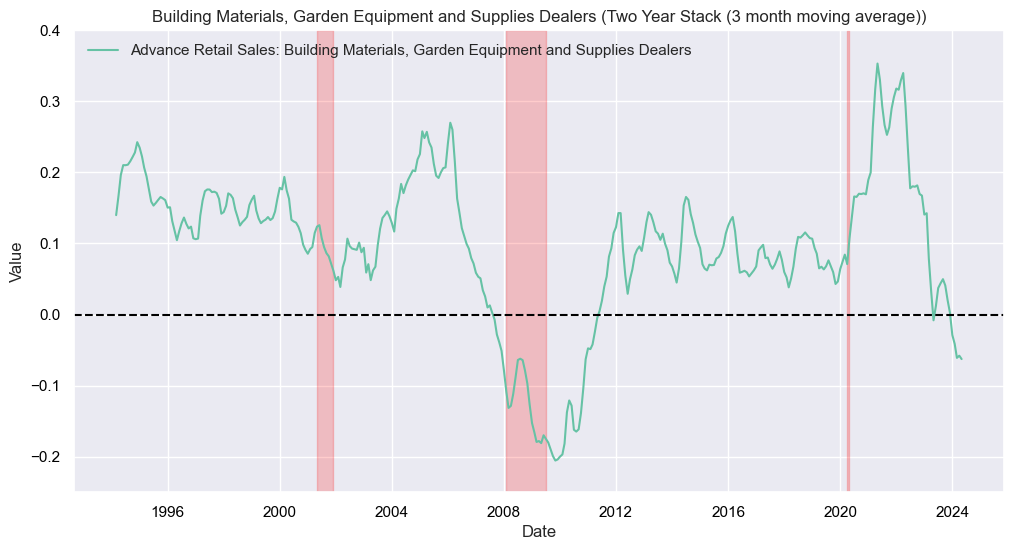

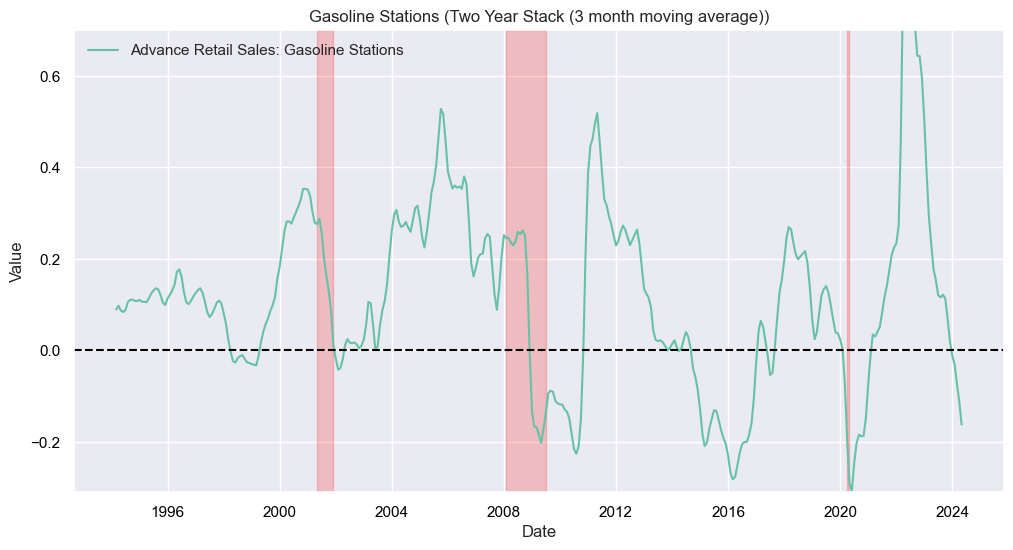

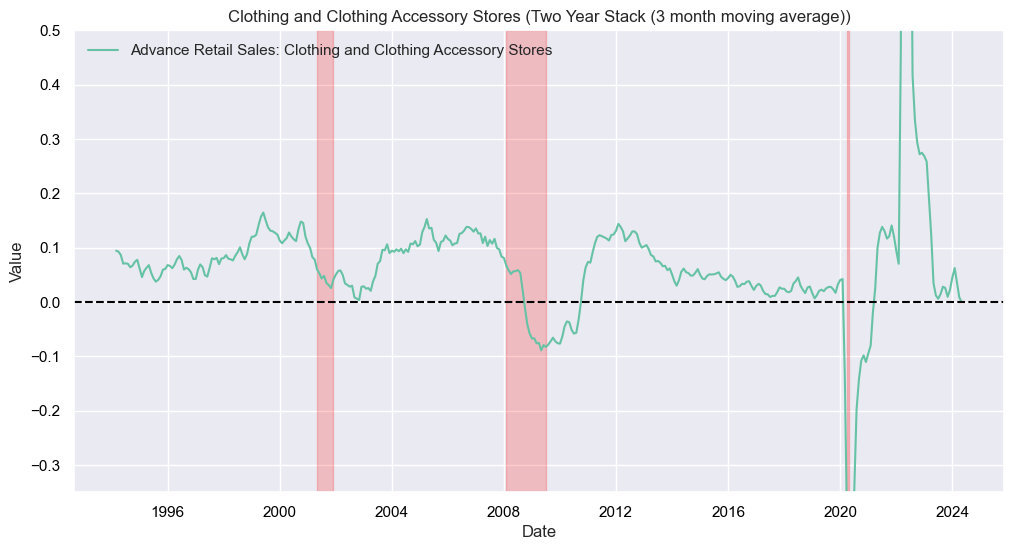

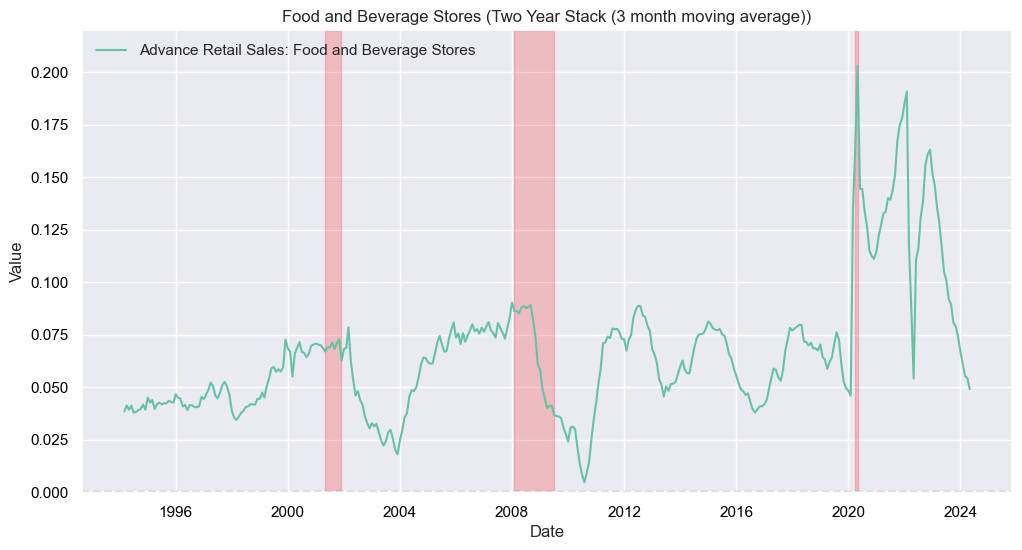

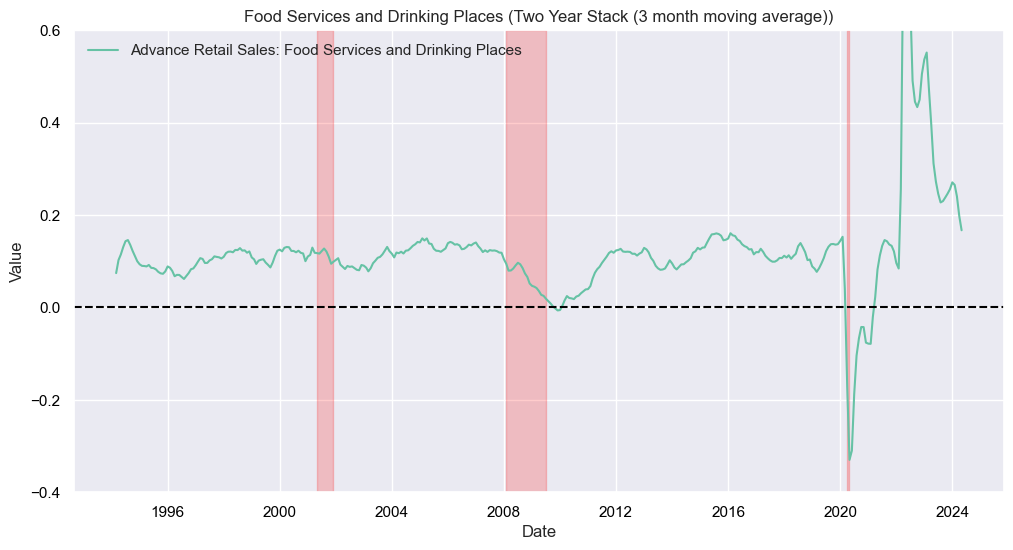

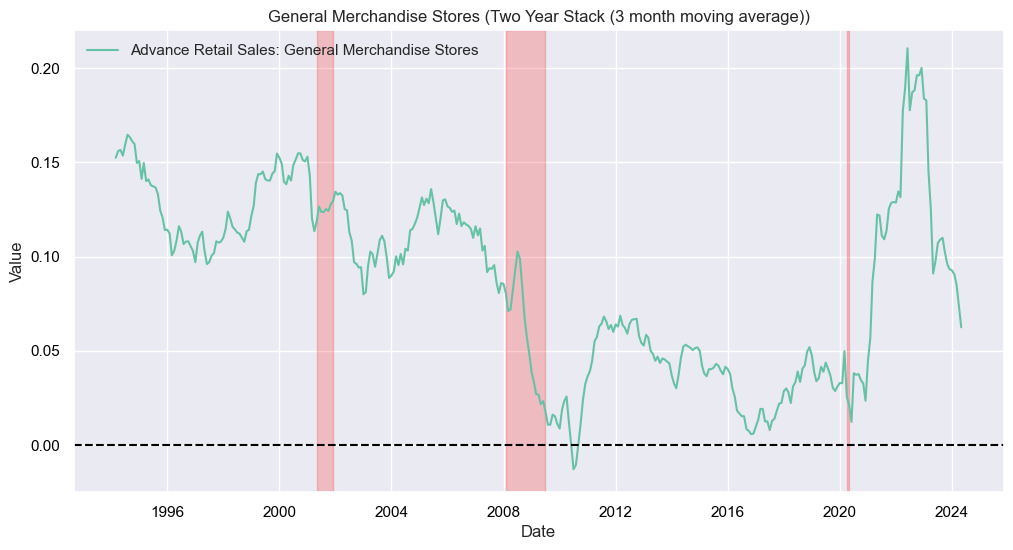

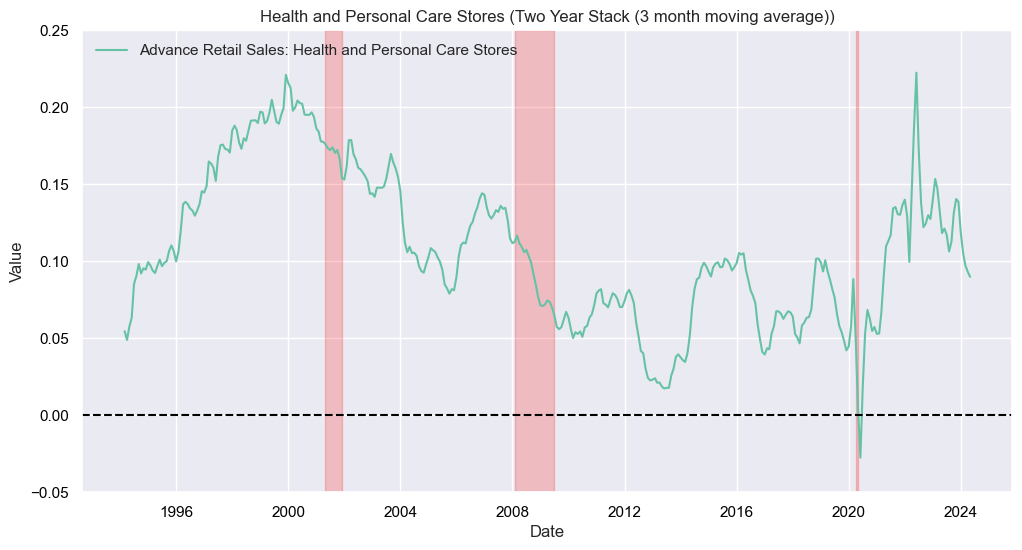

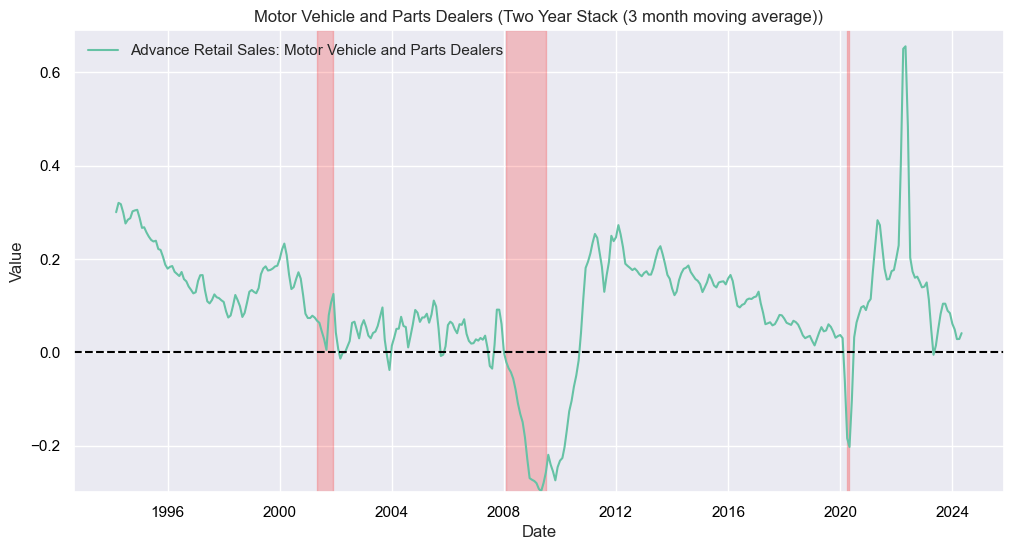

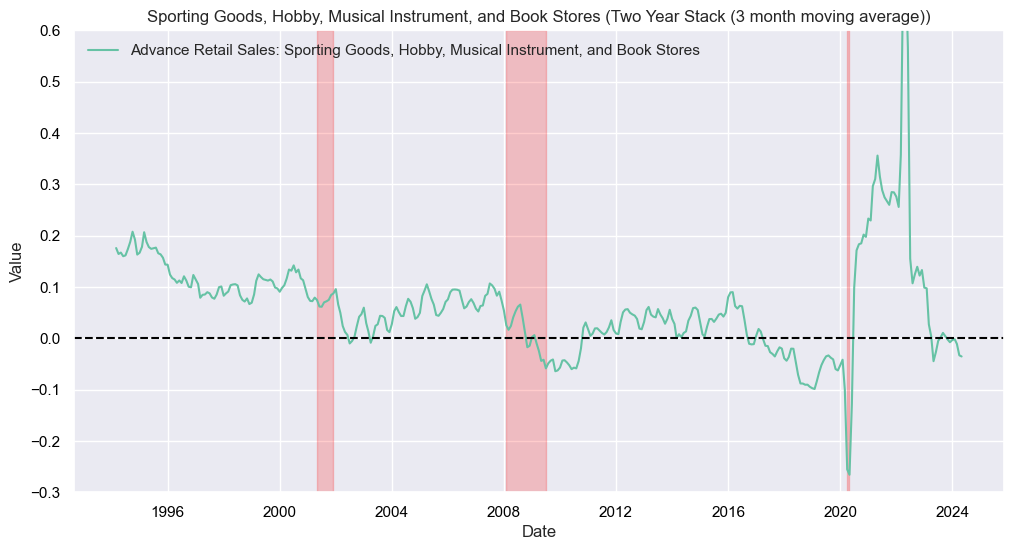

In [329]:
eco_plot(all_2y[["Advance Retail Sales: Retail Trade and Food Services, Excluding Motor Vehicle and Parts Dealers and Gasoline Stations"]].rolling(3).mean(), start, 
         end, 'Retail Sales, excluding Autos and Gasoline (Two Year Stack (3 month moving average))', -.05, .4, 00, 100, plot=True, save_fig=False)
eco_plot(all_2y[["Advance Retail Sales: Auto and Other Motor Vehicle Dealers"]].rolling(3).mean(), start, 
         end, 'Auto and Other Motor Vehicle Dealers (Two Year Stack (3 month moving average))', -.35, .75, 00, 100, plot=True, save_fig=False)
eco_plot(all_2y[["Advance Retail Sales: Nonstore Retailers"]].rolling(3).mean(), start, 
         end, 'Nonstore Retailers (Two Year Stack (3 month moving average))', -.05, .6, 00, 100, plot=True, save_fig=False)
eco_plot(all_2y[["Advance Retail Sales: Electronics and Appliance Stores"]].rolling(3).mean(), start, 
         end, 'Electronics and Appliance Stores (Two Year Stack (3 month moving average))', -.35, .75, 00, 100, plot=True, save_fig=False)
eco_plot(all_2y[["Advance Retail Sales: Furniture and Home Furnishings Stores"]].rolling(3).mean(), start, 
         end, 'Furniture and Home Furnishings Stores (Two Year Stack (3 month moving average))', -.4, .4, 00, 100, plot=True, save_fig=False)
eco_plot(all_2y[["Advance Retail Sales: Miscellaneous Store Retailers"]].rolling(3).mean(), start, 
         end, 'Miscellaneous Store Retailers (Two Year Stack (3 month moving average))', -.21, .7, 00, 100, plot=True, save_fig=False)
eco_plot(all_2y[["Advance Retail Sales: Building Materials, Garden Equipment and Supplies Dealers"]].rolling(3).mean(), start, 
         end, 'Building Materials, Garden Equipment and Supplies Dealers (Two Year Stack (3 month moving average))', -.25, .4, 00, 100, plot=True, save_fig=False)
eco_plot(all_2y[["Advance Retail Sales: Gasoline Stations"]].rolling(3).mean(), start, 
         end, 'Gasoline Stations (Two Year Stack (3 month moving average))', -.31, .7, 00, 100, plot=True, save_fig=False)
eco_plot(all_2y[["Advance Retail Sales: Clothing and Clothing Accessory Stores"]].rolling(3).mean(), start, 
         end, 'Clothing and Clothing Accessory Stores (Two Year Stack (3 month moving average))', -.35, .5, 00, 100, plot=True, save_fig=False)
eco_plot(all_2y[["Advance Retail Sales: Food and Beverage Stores"]].rolling(3).mean(), start, 
         end, 'Food and Beverage Stores (Two Year Stack (3 month moving average))', -.0, .22, 00, 100, plot=True, save_fig=False)
eco_plot(all_2y[["Advance Retail Sales: Food Services and Drinking Places"]].rolling(3).mean(), start, 
         end, 'Food Services and Drinking Places (Two Year Stack (3 month moving average))', -0.4, 0.6, 00, 100, plot=True, save_fig=False)
eco_plot(all_2y[["Advance Retail Sales: General Merchandise Stores"]].rolling(3).mean(), start, 
         end, 'General Merchandise Stores (Two Year Stack (3 month moving average))', -.025, 0.22, 00, 100, plot=True, save_fig=False)
eco_plot(all_2y[["Advance Retail Sales: Health and Personal Care Stores"]].rolling(3).mean(), start, 
         end, 'Health and Personal Care Stores (Two Year Stack (3 month moving average))', -.05, .25, 00, 100, plot=True, save_fig=False)
eco_plot(all_2y[["Advance Retail Sales: Motor Vehicle and Parts Dealers"]].rolling(3).mean(), start, 
         end, 'Motor Vehicle and Parts Dealers (Two Year Stack (3 month moving average))', -.3, 0.69, 00, 100, plot=True, save_fig=False)
eco_plot(all_2y[["Advance Retail Sales: Sporting Goods, Hobby, Musical Instrument, and Book Stores"]].rolling(3).mean(), start, 
         end, 'Sporting Goods, Hobby, Musical Instrument, and Book Stores (Two Year Stack (3 month moving average))', -.3, .6, 00, 100, plot=True, save_fig=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


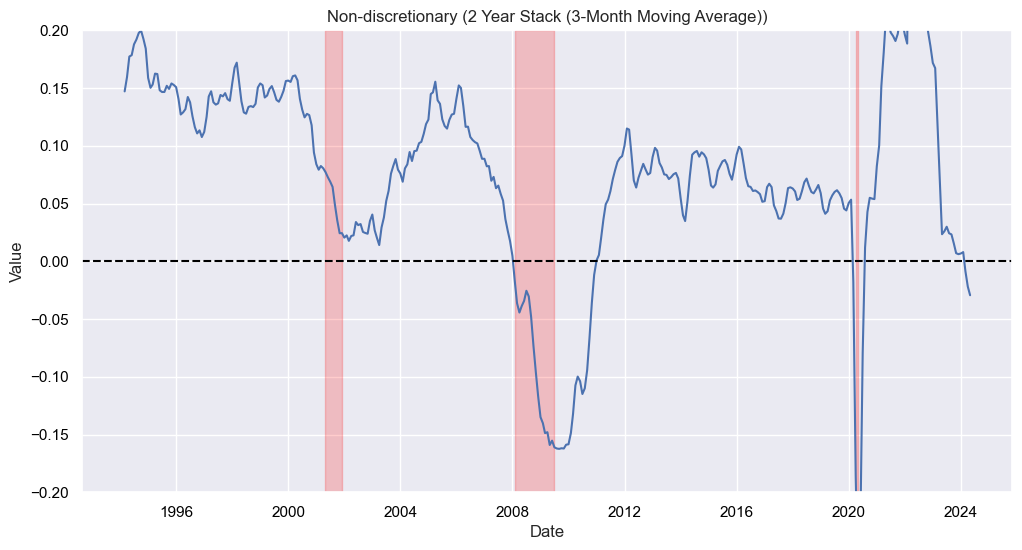

In [345]:
nondiscretionary = all_2y[["Advance Retail Sales: Building Materials, Garden Equipment and Supplies Dealers","Advance Retail Sales: Clothing and Clothing Accessory Stores",
        "Advance Retail Sales: Furniture and Home Furnishings Stores","Advance Retail Sales: Miscellaneous Store Retailers"]].rolling(3).mean().mean(axis=1)
eco_plot(nondiscretionary, start, end, 'Non-discretionary (2 Year Stack (3-Month Moving Average))', -.2, .2, 00, 100, plot=True, save_fig=False)

Food Services and Drinking Places Slowdown

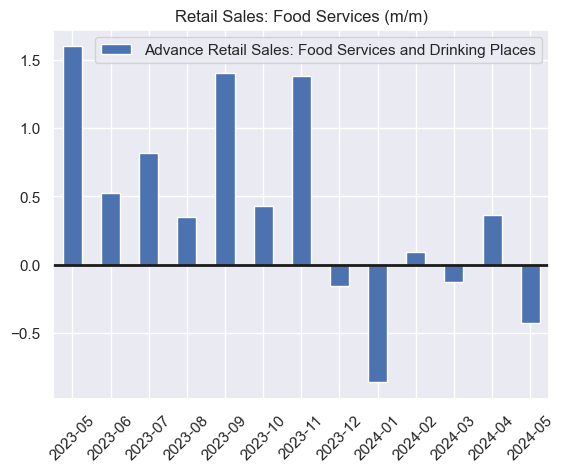

In [281]:
food_serv = (all_mm[['Advance Retail Sales: Food Services and Drinking Places']].tail(13)*100)
ax = food_serv.plot.bar(stacked=False, grid=True, xlabel='', rot=45,title = "Retail Sales: Food Services (m/m)")
ax.axhline(y=0, lw=2, c='k')
ax.legend(loc='best')  # upper right, lower right 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, food_serv.index)))

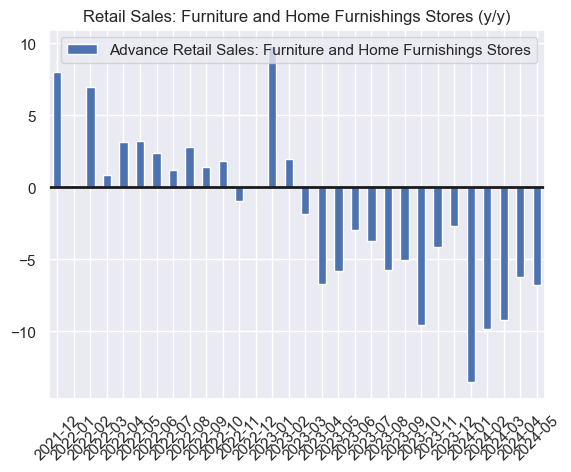

In [328]:
food_serv = (all_yy[['Advance Retail Sales: Furniture and Home Furnishings Stores']].tail(30)*100)
ax = food_serv.plot.bar(stacked=False, grid=True, xlabel='', rot=45,title = "Retail Sales: Furniture and Home Furnishings Stores (y/y)")
ax.axhline(y=0, lw=2, c='k')
ax.legend(loc='best')  # upper right, lower right 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, food_serv.index)))

In [ ]:
food_serv = (all_mm[['Advance Retail Sales: Food Services and Drinking Places']].tail(13)*100)
ax = food_serv.plot.bar(stacked=False, grid=True, xlabel='', rot=45,title = "Retail Sales: Food Services (m/m)")
ax.axhline(y=0, lw=2, c='k')
ax.legend(loc='best')  # upper right, lower right 
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, food_serv.index)))

In [218]:
levels = all[['Advance Retail Sales: Building Materials, Garden Equipment and Supplies Dealers',
       'Advance Retail Sales: Clothing and Clothing Accessory Stores',
       'Advance Retail Sales: Food and Beverage Stores',
       'Advance Retail Sales: Electronics and Appliance Stores',
       'Advance Retail Sales: Furniture and Home Furnishings Stores',
       'Advance Retail Sales: Food Services and Drinking Places',
       'Advance Retail Sales: Gasoline Stations',
       'Advance Retail Sales: General Merchandise Stores',
       'Advance Retail Sales: Health and Personal Care Stores',
       'Advance Retail Sales: Miscellaneous Store Retailers',
       'Advance Retail Sales: Motor Vehicle and Parts Dealers',
       'Advance Retail Sales: Nonstore Retailers',
       'Advance Retail Sales: Sporting Goods, Hobby, Musical Instrument, and Book Stores']]

levels = levels.rename(columns = lambda x: x.replace('Advance Retail Sales: ', ''))
levels1 = levels.tail(1).T.reset_index()
levels1.columns.values[1] = "Nominal Retail Sales"

fig = px.pie(levels1, values='Nominal Retail Sales', names='ticker',
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title_text='Retail Sales Level 1 Components (Weights) - May 2024', title_x=0.5)
fig.show()

In [219]:
levels = all[['Advance Retail Sales: Building Materials, Garden Equipment and Supplies Dealers',
       'Advance Retail Sales: Clothing and Clothing Accessory Stores',
       'Advance Retail Sales: Food and Beverage Stores',
       'Advance Retail Sales: Electronics and Appliance Stores',
       'Advance Retail Sales: Furniture and Home Furnishings Stores',
       'Advance Retail Sales: Food Services and Drinking Places',
       'Advance Retail Sales: Gasoline Stations',
       'Advance Retail Sales: General Merchandise Stores',
       'Advance Retail Sales: Health and Personal Care Stores',
       'Advance Retail Sales: Miscellaneous Store Retailers',
       'Advance Retail Sales: Motor Vehicle and Parts Dealers',
       'Advance Retail Sales: Nonstore Retailers',
       'Advance Retail Sales: Sporting Goods, Hobby, Musical Instrument, and Book Stores']]

levels = levels.rename(columns = lambda x: x.replace('Advance Retail Sales: ', ''))
levels2 = levels['2011-05-01':'2011-05-01'].T.reset_index()
levels2.columns.values[1] = "Nominal Retail Sales"
fig = px.pie(levels2, values='Nominal Retail Sales', names='ticker',
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title_text='Retail Sales Level 1 Components (Weights) - May 2011', title_x=0.5)
fig.show()

In [216]:
levels = all[['Advance Retail Sales: Building Materials, Garden Equipment and Supplies Dealers',
       'Advance Retail Sales: Clothing and Clothing Accessory Stores',
       'Advance Retail Sales: Food and Beverage Stores',
       'Advance Retail Sales: Electronics and Appliance Stores',
       'Advance Retail Sales: Furniture and Home Furnishings Stores',
       'Advance Retail Sales: Food Services and Drinking Places',
       'Advance Retail Sales: Gasoline Stations',
       'Advance Retail Sales: General Merchandise Stores',
       'Advance Retail Sales: Health and Personal Care Stores',
       'Advance Retail Sales: Miscellaneous Store Retailers',
       'Advance Retail Sales: Motor Vehicle and Parts Dealers',
       'Advance Retail Sales: Nonstore Retailers',
       'Advance Retail Sales: Sporting Goods, Hobby, Musical Instrument, and Book Stores']]

levels = levels.rename(columns = lambda x: x.replace('Advance Retail Sales: ', ''))
levels2 = levels['2001-05-01':'2001-05-01'].T.reset_index()
levels2.columns.values[1] = "Nominal Retail Sales"
fig = px.pie(levels2, values='Nominal Retail Sales', names='ticker',
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title_text='Retail Sales Level 1 Components (Weights) - May 2001', title_x=0.5)
fig.show()

In [192]:
fig = px.treemap(levels1, path=[px.Constant("Advance Retail Sales: Retail Trade and Food Services"), 'ticker'], values="Nominal Retail Sales",
                  color='Nominal Retail Sales',
                  color_continuous_scale='RdYlGn',
                  height = 1000,
                  width = 1900)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.update_layout(uniformtext=dict(minsize=15, mode='show'))

fig.show()